### This Loop is going to do a few things. Mainly, I am trying to save the Skill Scores of this NAO Model->Temp to look at how well it's performing.

I may tack on some of those bar plots from Mayer and Barnes (2021) here at the end. 

I will have a separate coding file to do LRP. 

In [1]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

#plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
import innvestigate

/tmp/ipykernel_2555827/2580141331.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-11-21 15:39:55.857159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 15:39:55.857229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 15:39:55.857273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Un

In [2]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS_two
from SkillStats_MOD import PAS_two
from climoprobs import climo

import random
import sklearn

In [3]:
#inputs ... CHANGE FOR WHATEVER REGION YOU WANT TO LOOK AT 
infile = open("../data/ANN/1118_filtered_gph.p", 'rb') 
input = pickle.load(infile)
infile.close()

infile = open("../data/ANN/1118_classmedian_filt.p", 'rb')
temp = pickle.load(infile)
infile.close()

#infile = open("../data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()

In [4]:
##checking shapes
print(input.shape)
print(temp.shape)

(63, 151, 21, 37)
(9513,)


In [5]:
temp = temp.reshape(63,151)

In [6]:
##introduce tw-day time lag
temp_n = np.zeros((63,149))
input_n = np.zeros((63,149,21,37))

for i in range(63):
    for j in range(149):
        temp_n[i,j] = temp[i,j+2]
        input_n[i,j] = input[i,j,:,:]
        

In [7]:
##Set X_all and Y_all datasets
X_all = np.copy(input_n.reshape(9387,777))
Y_all = np.copy(temp_n.reshape(9387))

##training data partition out
X_tri = X_all[:8791,:]
Y_tri = Y_all[:8791]

#testing data partition out
X_tes = X_all[8791:,:]
Y_tes = Y_all[8791:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [8]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin setting up parts of my model architecture.

The first few cells here are for partitioning data and setting up lists to save skill scores. 

In [9]:
##set fraction of data as 6 years
frac_ind = 149*6
frac_ind

894

In [10]:
##number of input nodes, (lat*lon)
numb_int = X_all.shape[-1]

In [11]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = []

In [12]:
##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

In [13]:
####for LRP
comp_pos = np.empty((100,777))
comp_neg = np.empty((100,777))
compFpos = np.empty((100,777))
compFneg = np.empty((100,777))

pos90_LRP= np.empty((100,21,37))
neg90_LRP= np.empty((100,21,37))
Fpos90_LRP= np.empty((100,21,37))
Fneg90_LRP= np.empty((100,21,37))

In [14]:
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

### Model architecture specifics start here.

In [15]:
###### batch, epochs, etc
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [16]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [17]:
##DEFINITION STATEMENT FOR MODEL ITSELF
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    ##input tensor has the shape of the number of nodes, 777
    input_tensor = Input(shape=(int(number_inputs),))
    #first dense layer
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    #second dense layer
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)
    #decay_rate = learn / epochs ###option for decaying learning rate
    #output layer with 2 categories
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [18]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [19]:
##Early Stopping Condition, if desired
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [20]:
##full dataset climo probabilities 
climo_full = climo(Y_all,63,149)

In [21]:
##create loop for cross validation
for l in range(0,100):
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 6 year window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining 53 years of training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]

    climo_train1 = climo_full[0:start,:]
    climo_train2 = climo_full[end:8791,:]

    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##pause, calculate climo probabilities
    climo_val = climo_full[start:end,:]
    climo_test = climo_full[8791:,:]

    ##initalize model
    #model = basic_ANN(numb_int, 2, 128, 8, 0.08, 0.07, 0.0025, epochs)
    model = basic_ANN(numb_int, 2, 128, 4, 0.38, 0.64, 0.001, epochs)
    ##FIT the model

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
     
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    ##BRIER SKILL SCORE
    BSS(l, start, end,
        climo_full, pred, Y_all, BSS_all,
        climo_val, pred_val, Y_val, BSS_val,
        climo_train, pred_train, Y_tr, BSS_train,
        climo_test, pred_test, Y_tes, BSS_test)
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))

    ##TRAINING
    q90 = np.percentile(pred_train,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_train) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    train90 = pred_train[great90]
    train90_norm = Y_tr[great90]
    train90_acc.append(calculate_accuracy(train90_norm, train90, threshold=0.5))
    ##full model
    fulltrain_acc.append(calculate_accuracy(Y_tr, pred_train, threshold=0.5))

    ##VALIDATION
    q90 = np.percentile(pred_val,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = great90 = [i for i, row in enumerate(pred_val) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    val90 = pred_val[great90]
    val90_norm = Y_val[great90]
    val90_acc.append(calculate_accuracy(val90_norm, val90, threshold=0.5))
    ##full model
    fullval_acc.append(calculate_accuracy(Y_val, pred_val, threshold=0.5))

    
    ########################################################################################################
    ##LRP
    # Creating an analyzer
    #model_wo_sm = innvestigate.model_wo_softmax(model)
    #gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer
    #analysis = gradient_analyzer.analyze(X_tr)
    #tf.keras.backend.clear_session()

    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    #LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

    #Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
    #LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

    #Now take the mean across all samples to make a composite...
    #LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

    #LRP[l,:,:] = LRP_heatmaps_mean[:,:]

    ##I am going to transition right here into making separate LRP for the top 10% most confident and correct
    #predictions in the testing data 
    q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
    ##AS before with checking the threshold
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative
    
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')
            
    # Creating an analyzer
    model_wo_sm = innvestigate.model_wo_softmax(model)
    gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)
    ##apply the analyzer to testing data
    ##correct positive
    posXtest = X_tes[correct_pos]
    comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
    posXtest_grad = gradient_analyzer.analyze(posXtest)
    #false positive
    FposXtest = X_tes[false_pos]
    compFpos[l,:] = np.nanmean(FposXtest,axis=0) #save for composite
    FposXtest_grad = gradient_analyzer.analyze(FposXtest)
    #correct negative
    negXtest = X_tes[correct_neg]
    comp_neg[l,:] = np.nanmean(negXtest,axis=0) #save for composite
    negXtest_grad = gradient_analyzer.analyze(negXtest)
    #false negative
    FnegXtest = X_tes[false_neg]
    compFneg[l,:] = np.nanmean(FnegXtest,axis=0) #save for composite
    FnegXtest_grad = gradient_analyzer.analyze(FnegXtest)
    
    ###make heatmap
    ##CORRECT PLOTS
    pos = np.array(posXtest_grad)
    pos.reshape((len(posXtest_grad),777))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    posLRP_heatmaps = pos.reshape(pos.shape[0], 21, 37)
    posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    posLRP_heatmaps_mean = np.nanmean(posLRP_heatmaps_scaled, axis=0)
    pos90_LRP[l,:,:] = posLRP_heatmaps_mean[:,:]
    
    neg = np.array(negXtest_grad )
    neg.reshape((len(negXtest_grad),777))
    negLRP_heatmaps = neg.reshape(neg.shape[0], 21, 37)
    negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    negLRP_heatmaps_mean = np.nanmean(negLRP_heatmaps_scaled, axis=0)
    neg90_LRP[l,:,:] = negLRP_heatmaps_mean[:,:]

    ###FALSE PLOTS
    Fpos = np.array(FposXtest_grad)
    Fpos.reshape((len(FposXtest_grad),777))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    FposLRP_heatmaps = Fpos.reshape(Fpos.shape[0], 21, 37)
    FposLRP_heatmaps_scaled = FposLRP_heatmaps/np.nanmax(FposLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FposLRP_heatmaps_mean = np.nanmean(FposLRP_heatmaps_scaled, axis=0)
    Fpos90_LRP[l,:,:] = FposLRP_heatmaps_mean[:,:]
    
    Fneg = np.array(FnegXtest_grad )
    Fneg.reshape((len(FnegXtest_grad),777))
    FnegLRP_heatmaps = Fneg.reshape(Fneg.shape[0], 21, 37)
    FnegLRP_heatmaps_scaled = FnegLRP_heatmaps/np.nanmax(FnegLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FnegLRP_heatmaps_mean = np.nanmean(FnegLRP_heatmaps_scaled, axis=0)
    Fneg90_LRP[l,:,:] = FnegLRP_heatmaps_mean[:,:]

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 93.8796 - categorical_accuracy: 0.4697 

2024-11-21 15:39:58.383082: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-21 15:39:58.413883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-21 15:39:58.448743: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/kernel/v/Assign' id:399 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/kernel/v, training/Adam/dense_2/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation w

7897/7897 [==============================] - 0s 24us/sample - loss: 86.2047 - categorical_accuracy: 0.5011 - val_loss: 64.0052 - val_categorical_accuracy: 0.6107
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 47.8579 - categorical_accuracy: 0.6214 - val_loss: 33.4564 - val_categorical_accuracy: 0.6286
Epoch 3/50
5376/7897 [===================>..........] - ETA: 0s - loss: 27.2291 - categorical_accuracy: 0.6427

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 24.7498 - categorical_accuracy: 0.6376 - val_loss: 17.2637 - val_categorical_accuracy: 0.6398
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 12.9550 - categorical_accuracy: 0.6440 - val_loss: 9.2681 - val_categorical_accuracy: 0.6454
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 7.1331 - categorical_accuracy: 0.6459 - val_loss: 5.3024 - val_categorical_accuracy: 0.6298
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 4.2681 - categorical_accuracy: 0.6501 - val_loss: 3.4635 - val_categorical_accuracy: 0.6477
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 2.8701 - categorical_accuracy: 0.6509 - val_loss: 2.4051 - val_categorical_accuracy: 0.6275
Epoch 8/50
7897/7897 [==============================] - 0s 11us/sample - loss: 2.0735 - categorical_accuracy: 0.6523 - val_loss: 1.7898 - val_categorical

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-21 15:40:01.748061: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/Softmax' id:88 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:02.396279: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_1/Assign' id:613 op device:{requested: '', assigned: ''} def:{{{node kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kern

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 96.3502 - categorical_accuracy: 0.5603 

2024-11-21 15:40:02.974585: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_4/kernel/v/Assign' id:1211 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_4/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_4/kernel/v, training_2/Adam/dense_4/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 23us/sample - loss: 89.8510 - categorical_accuracy: 0.5643 - val_loss: 69.0815 - val_categorical_accuracy: 0.5604
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 53.2037 - categorical_accuracy: 0.6196 - val_loss: 38.6918 - val_categorical_accuracy: 0.5872
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 29.4190 - categorical_accuracy: 0.6440 - val_loss: 21.3412 - val_categorical_accuracy: 0.5884
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.3880 - categorical_accuracy: 0.6532 - val_loss: 12.1438 - val_categorical_accuracy: 0.6186
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 9.5481 - categorical_accuracy: 0.6623 - val_loss: 7.3546 - val_categorical_accuracy: 0.6096
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 5.9749 - categorical_accuracy: 0.6622 - val_loss: 4.8179 - val_catego

2024-11-21 15:40:06.489941: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6/Softmax' id:922 op device:{requested: '', assigned: ''} def:{{{node dense_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:06.957107: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_7/Assign' id:1407 op device:{requested: '', assigned: ''} def:{{{node kernel_7/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_7, kernel_7/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 102.7952 - categorical_accuracy: 0.5653

2024-11-21 15:40:07.700565: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/learning_rate/Assign' id:2004 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/learning_rate, training_4/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 26us/sample - loss: 97.3170 - categorical_accuracy: 0.5598 - val_loss: 80.4476 - val_categorical_accuracy: 0.5112
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 67.1955 - categorical_accuracy: 0.5194 - val_loss: 53.9882 - val_categorical_accuracy: 0.5224
Epoch 3/50
7897/7897 [==============================] - 0s 10us/sample - loss: 44.1535 - categorical_accuracy: 0.5847 - val_loss: 34.8735 - val_categorical_accuracy: 0.6409
Epoch 4/50
7897/7897 [==============================] - 0s 10us/sample - loss: 28.4239 - categorical_accuracy: 0.6373 - val_loss: 22.4594 - val_categorical_accuracy: 0.6667
Epoch 5/50
7897/7897 [==============================] - 0s 10us/sample - loss: 18.3931 - categorical_accuracy: 0.6499 - val_loss: 14.6646 - val_categorical_accuracy: 0.6723
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 12.1029 - categorical_accuracy: 0.6578 - val_loss: 9.8117 - val_cat

2024-11-21 15:40:12.212943: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_10/Softmax' id:1754 op device:{requested: '', assigned: ''} def:{{{node dense_10/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_10/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:12.727046: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_2/Assign' id:2244 op device:{requested: '', assigned: ''} def:{{{node bias_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_2, bias_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:12.779926:

Train on 7897 samples, validate on 894 samples
Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 100.4759 - categorical_accuracy: 0.5160

2024-11-21 15:40:13.661940: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/beta_1/Assign' id:2821 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/beta_1, training_6/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 29us/sample - loss: 94.0277 - categorical_accuracy: 0.5122 - val_loss: 77.0247 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 62.9466 - categorical_accuracy: 0.5002 - val_loss: 49.2205 - val_categorical_accuracy: 0.4955
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 49.2221 - categorical_accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 39.4596 - categorical_accuracy: 0.5012 - val_loss: 30.4578 - val_categorical_accuracy: 0.4966
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 24.4116 - categorical_accuracy: 0.5021 - val_loss: 18.9219 - val_categorical_accuracy: 0.4944
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 15.3255 - categorical_accuracy: 0.5231 - val_loss: 12.0727 - val_categorical_accuracy: 0.5593
Epoch 6/50
7897/7897 [==============================] - 0s 10us/sample - loss: 9.9460 - categorical_accuracy: 0.5354 - val_loss: 8.0429 - val_categorical_accuracy: 0.5034
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 6.7835 - categorical_accuracy: 0.5457 - val_loss: 5.6239 - val_categorical_accuracy: 0.5403
Epoch 8/50
7897/7897 [==============================] - 0s 12us/sample - loss: 4.8482 - categorical_accuracy: 0.5396 - val_loss: 4.1159 - val_categori

2024-11-21 15:40:17.984904: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_14/Softmax' id:2586 op device:{requested: '', assigned: ''} def:{{{node dense_14/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_14/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:40:18.501232: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_21/Assign' id:3071 op device:{requested: '', assigned: ''} def:{{{node kernel_21/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_21, kernel_21/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 120.3572 - categorical_accuracy: 0.5186

2024-11-21 15:40:19.591295: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_17/bias/Assign' id:3388 op device:{requested: '', assigned: ''} def:{{{node dense_17/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_17/bias, dense_17/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 29us/sample - loss: 111.0226 - categorical_accuracy: 0.5127 - val_loss: 87.3274 - val_categorical_accuracy: 0.4899
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 77.3313 - categorical_accuracy: 0.5075 - val_loss: 66.9687 - val_categorical_accuracy: 0.4933
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 66.9518 - categorical_accuracy: 0.4805

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 12us/sample - loss: 58.5398 - categorical_accuracy: 0.5088 - val_loss: 50.2820 - val_categorical_accuracy: 0.4899
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 43.9055 - categorical_accuracy: 0.5443 - val_loss: 37.7742 - val_categorical_accuracy: 0.5369
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 33.0768 - categorical_accuracy: 0.5888 - val_loss: 28.6079 - val_categorical_accuracy: 0.5526
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 25.1572 - categorical_accuracy: 0.6125 - val_loss: 21.9467 - val_categorical_accuracy: 0.5872
Epoch 7/50
7897/7897 [==============================] - 0s 12us/sample - loss: 19.3558 - categorical_accuracy: 0.6459 - val_loss: 16.9925 - val_categorical_accuracy: 0.5906
Epoch 8/50
7897/7897 [==============================] - 0s 12us/sample - loss: 15.0695 - categorical_accuracy: 0.6635 - val_loss: 13.4244 - val_ca

2024-11-21 15:40:24.395843: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_18/Softmax' id:3418 op device:{requested: '', assigned: ''} def:{{{node dense_18/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_18/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:25.264329: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_33/Assign' id:4000 op device:{requested: '', assigned: ''} def:{{{node kernel_33/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_33, kernel_33/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 102.9648 - categorical_accuracy: 0.5316

2024-11-21 15:40:26.595183: W tensorflow/c/c_api.cc:305] Operation '{name:'training_10/Adam/dense_22/kernel/v/Assign' id:4541 op device:{requested: '', assigned: ''} def:{{{node training_10/Adam/dense_22/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_10/Adam/dense_22/kernel/v, training_10/Adam/dense_22/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 33us/sample - loss: 96.5838 - categorical_accuracy: 0.5221 - val_loss: 79.3531 - val_categorical_accuracy: 0.4955
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 66.0676 - categorical_accuracy: 0.4997 - val_loss: 53.2266 - val_categorical_accuracy: 0.4933
Epoch 3/50
 256/7897 [..............................] - ETA: 0s - loss: 53.0893 - categorical_accuracy: 0.5703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 43.6074 - categorical_accuracy: 0.4992 - val_loss: 34.7582 - val_categorical_accuracy: 0.4966
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 28.6196 - categorical_accuracy: 0.4997 - val_loss: 23.0230 - val_categorical_accuracy: 0.4933
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 19.1151 - categorical_accuracy: 0.5044 - val_loss: 15.5676 - val_categorical_accuracy: 0.4955
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 13.1512 - categorical_accuracy: 0.5161 - val_loss: 11.0230 - val_categorical_accuracy: 0.4955
Epoch 7/50
7897/7897 [==============================] - 0s 12us/sample - loss: 9.3834 - categorical_accuracy: 0.5196 - val_loss: 8.0228 - val_categorical_accuracy: 0.5134
Epoch 8/50
7897/7897 [==============================] - 0s 12us/sample - loss: 6.8612 - categorical_accuracy: 0.5273 - val_loss: 5.9121 - val_catego

2024-11-21 15:40:31.491591: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_22/Softmax' id:4232 op device:{requested: '', assigned: ''} def:{{{node dense_22/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_22/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:32.068257: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_35/Assign' id:4699 op device:{requested: '', assigned: ''} def:{{{node kernel_35/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_35, kernel_35/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
 256/7897 [..............................] - ETA: 1s - loss: 135.2419 - categorical_accuracy: 0.4688

2024-11-21 15:40:33.576797: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_25/bias/Assign' id:5016 op device:{requested: '', assigned: ''} def:{{{node dense_25/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_25/bias, dense_25/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 34us/sample - loss: 93.4394 - categorical_accuracy: 0.5099 - val_loss: 75.4840 - val_categorical_accuracy: 0.4911
Epoch 2/50
4864/7897 [=================>............] - ETA: 0s - loss: 66.5473 - categorical_accuracy: 0.5041

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 12us/sample - loss: 61.1954 - categorical_accuracy: 0.5036 - val_loss: 47.4109 - val_categorical_accuracy: 0.4911
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 37.8047 - categorical_accuracy: 0.5036 - val_loss: 29.0035 - val_categorical_accuracy: 0.4911
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 23.2261 - categorical_accuracy: 0.5035 - val_loss: 18.0591 - val_categorical_accuracy: 0.4911
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 14.6365 - categorical_accuracy: 0.4978 - val_loss: 11.5805 - val_categorical_accuracy: 0.5112
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 9.6456 - categorical_accuracy: 0.4989 - val_loss: 7.8991 - val_categorical_accuracy: 0.5045
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 6.6978 - categorical_accuracy: 0.4982 - val_loss: 5.5705 - val_catego

2024-11-21 15:40:37.827029: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_26/Softmax' id:5046 op device:{requested: '', assigned: ''} def:{{{node dense_26/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_26/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:40:38.419065: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_43/Assign' id:5569 op device:{requested: '', assigned: ''} def:{{{node kernel_43/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_43, kernel_43/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
 256/7897 [..............................] - ETA: 1s - loss: 125.0309 - categorical_accuracy: 0.5312

2024-11-21 15:40:40.101445: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_28/kernel/Assign' id:5804 op device:{requested: '', assigned: ''} def:{{{node dense_28/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_28/kernel, dense_28/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 39us/sample - loss: 89.7217 - categorical_accuracy: 0.5587 - val_loss: 69.5106 - val_categorical_accuracy: 0.5570
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 69.5111 - categorical_accuracy: 0.5820

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 54.2485 - categorical_accuracy: 0.5891 - val_loss: 40.1122 - val_categorical_accuracy: 0.6510
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 30.9564 - categorical_accuracy: 0.6358 - val_loss: 22.8443 - val_categorical_accuracy: 0.6432
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 17.8249 - categorical_accuracy: 0.6415 - val_loss: 13.3892 - val_categorical_accuracy: 0.6622
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 10.6722 - categorical_accuracy: 0.6466 - val_loss: 8.2743 - val_categorical_accuracy: 0.6465
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 6.7632 - categorical_accuracy: 0.6524 - val_loss: 5.3894 - val_categorical_accuracy: 0.6946
Epoch 7/50
7897/7897 [==============================] - 0s 12us/sample - loss: 4.5672 - categorical_accuracy: 0.6540 - val_loss: 3.7775 - val_categor

2024-11-21 15:40:44.645330: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_30/Softmax' id:5878 op device:{requested: '', assigned: ''} def:{{{node dense_30/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_30/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:45.276006: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_54/Assign' id:6478 op device:{requested: '', assigned: ''} def:{{{node kernel_54/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_54, kernel_54/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50
 256/7897 [..............................] - ETA: 1s - loss: 118.2496 - categorical_accuracy: 0.5039

2024-11-21 15:40:47.244153: W tensorflow/c/c_api.cc:305] Operation '{name:'count_8/Assign' id:6720 op device:{requested: '', assigned: ''} def:{{{node count_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_8, count_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 42us/sample - loss: 86.3344 - categorical_accuracy: 0.5160 - val_loss: 64.1646 - val_categorical_accuracy: 0.4955
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 64.1054 - categorical_accuracy: 0.4883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 47.8490 - categorical_accuracy: 0.5091 - val_loss: 33.3345 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 24.5632 - categorical_accuracy: 0.5387 - val_loss: 17.1373 - val_categorical_accuracy: 0.5157
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 12.8370 - categorical_accuracy: 0.5657 - val_loss: 9.2895 - val_categorical_accuracy: 0.5436
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 7.1725 - categorical_accuracy: 0.5515 - val_loss: 5.4212 - val_categorical_accuracy: 0.5224
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 4.3587 - categorical_accuracy: 0.5754 - val_loss: 3.5292 - val_categorical_accuracy: 0.5671
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 2.9195 - categorical_accuracy: 0.6243 - val_loss: 2.4774 - val_categoric

2024-11-21 15:40:50.150236: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_34/Softmax' id:6710 op device:{requested: '', assigned: ''} def:{{{node dense_34/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_34/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:51.038871: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_61/Assign' id:7310 op device:{requested: '', assigned: ''} def:{{{node kernel_61/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_61, kernel_61/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-21 15:40:53.213249: W tensorflow/c/c_api.cc:305] Operation '{name:'training_18/Adam/beta_2/Assign' id:7782 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/beta_2, training_18/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 45us/sample - loss: 99.2726 - categorical_accuracy: 0.5284 - val_loss: 82.1246 - val_categorical_accuracy: 0.5145
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 82.1200 - categorical_accuracy: 0.5391

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 69.6207 - categorical_accuracy: 0.5026 - val_loss: 57.0985 - val_categorical_accuracy: 0.5089
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 47.6967 - categorical_accuracy: 0.5020 - val_loss: 38.7559 - val_categorical_accuracy: 0.5022
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 32.4010 - categorical_accuracy: 0.5045 - val_loss: 26.4421 - val_categorical_accuracy: 0.5067
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 22.2666 - categorical_accuracy: 0.5058 - val_loss: 18.3960 - val_categorical_accuracy: 0.5123
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 15.6324 - categorical_accuracy: 0.5096 - val_loss: 13.0755 - val_categorical_accuracy: 0.5235
Epoch 7/50
7897/7897 [==============================] - 0s 11us/sample - loss: 11.2891 - categorical_accuracy: 0.5193 - val_loss: 9.6081 - val_cat

2024-11-21 15:40:58.313475: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_38/Softmax' id:7542 op device:{requested: '', assigned: ''} def:{{{node dense_38/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_38/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:40:59.009005: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_66/Assign' id:8085 op device:{requested: '', assigned: ''} def:{{{node kernel_66/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_66, kernel_66/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-21 15:41:01.346892: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/beta_1/Assign' id:8591 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/beta_1, training_20/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7897/7897 [==============================] - 0s 45us/sample - loss: 94.8272 - categorical_accuracy: 0.5340 - val_loss: 76.9007 - val_categorical_accuracy: 0.5246
Epoch 2/50
 256/7897 [..............................] - ETA: 0s - loss: 76.8320 - categorical_accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 11us/sample - loss: 63.3878 - categorical_accuracy: 0.5189 - val_loss: 50.1392 - val_categorical_accuracy: 0.5089
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 40.5443 - categorical_accuracy: 0.5141 - val_loss: 31.6407 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 25.6008 - categorical_accuracy: 0.5372 - val_loss: 20.1135 - val_categorical_accuracy: 0.5224
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.4562 - categorical_accuracy: 0.5758 - val_loss: 13.1651 - val_categorical_accuracy: 0.5649
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 10.8900 - categorical_accuracy: 0.6177 - val_loss: 8.9015 - val_categorical_accuracy: 0.6107
Epoch 7/50
7897/7897 [==============================] - 0s 12us/sample - loss: 7.4580 - categorical_accuracy: 0.6448 - val_loss: 6.2125 - val_categ

2024-11-21 15:41:05.153125: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_42/Softmax' id:8356 op device:{requested: '', assigned: ''} def:{{{node dense_42/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_42/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:05.866034: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_70/Assign' id:8841 op device:{requested: '', assigned: ''} def:{{{node kernel_70/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_70, kernel_70/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7897 samples, validate on 894 samples
Epoch 1/50


2024-11-21 15:41:08.538105: W tensorflow/c/c_api.cc:305] Operation '{name:'training_22/Adam/iter/Assign' id:9418 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_22/Adam/iter, training_22/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


5120/7897 [==================>...........] - ETA: 0s - loss: 101.4917 - categorical_accuracy: 0.5053

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 49us/sample - loss: 95.8313 - categorical_accuracy: 0.5073 - val_loss: 79.7128 - val_categorical_accuracy: 0.5190
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 66.4512 - categorical_accuracy: 0.5009 - val_loss: 53.3109 - val_categorical_accuracy: 0.5201
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 43.6350 - categorical_accuracy: 0.5008 - val_loss: 34.5536 - val_categorical_accuracy: 0.5246
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 28.2244 - categorical_accuracy: 0.4926 - val_loss: 22.3797 - val_categorical_accuracy: 0.5302
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 18.3616 - categorical_accuracy: 0.5430 - val_loss: 14.6594 - val_categorical_accuracy: 0.6141
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 12.1490 - categorical_accuracy: 0.5979 - val_loss: 9.8270 - val_cat

2024-11-21 15:41:13.315271: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_46/Softmax' id:9188 op device:{requested: '', assigned: ''} def:{{{node dense_46/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_46/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:14.063365: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_80/Assign' id:9749 op device:{requested: '', assigned: ''} def:{{{node kernel_80/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_80, kernel_80/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples


2024-11-21 15:41:16.874106: W tensorflow/c/c_api.cc:305] Operation '{name:'training_24/Adam/beta_2/Assign' id:10260 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/beta_2, training_24/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 99.7132 - categorical_accuracy: 0.5199 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 54us/sample - loss: 92.1282 - categorical_accuracy: 0.5174 - val_loss: 72.6104 - val_categorical_accuracy: 0.5526
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 57.9370 - categorical_accuracy: 0.5963 - val_loss: 44.1933 - val_categorical_accuracy: 0.6107
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 34.9831 - categorical_accuracy: 0.6335 - val_loss: 26.6840 - val_categorical_accuracy: 0.6219
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 21.3167 - categorical_accuracy: 0.6462 - val_loss: 16.5110 - val_categorical_accuracy: 0.6264
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 13.4253 - categorical_accuracy: 0.6524 - val_loss: 10.6474 - val_categorical_accuracy: 0.6331
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 8.8237 - categorical_accuracy: 0.6601 - val_loss: 7.1744 - val_cate

2024-11-21 15:41:21.944979: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_50/Softmax' id:10020 op device:{requested: '', assigned: ''} def:{{{node dense_50/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_50/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:23.083472: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_87/Assign' id:10581 op device:{requested: '', assigned: ''} def:{{{node kernel_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_87, kernel_87/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new s

Train on 7897 samples, validate on 894 samples


2024-11-21 15:41:26.190252: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_54/kernel/Assign' id:10841 op device:{requested: '', assigned: ''} def:{{{node dense_54/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_54/kernel, dense_54/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 101.1273 - categorical_accuracy: 0.5111

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 54us/sample - loss: 94.2225 - categorical_accuracy: 0.5037 - val_loss: 77.4705 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 63.7250 - categorical_accuracy: 0.6254 - val_loss: 50.3846 - val_categorical_accuracy: 0.6365
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 40.8961 - categorical_accuracy: 0.6521 - val_loss: 32.1139 - val_categorical_accuracy: 0.6521
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 26.1642 - categorical_accuracy: 0.6605 - val_loss: 20.7190 - val_categorical_accuracy: 0.6465
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 17.0589 - categorical_accuracy: 0.6648 - val_loss: 13.7189 - val_categorical_accuracy: 0.6488
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 11.4681 - categorical_accuracy: 0.6670 - val_loss: 9.4072 - val_cat

2024-11-21 15:41:30.977796: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_54/Softmax' id:10852 op device:{requested: '', assigned: ''} def:{{{node dense_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:31.811898: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_97/Assign' id:11466 op device:{requested: '', assigned: ''} def:{{{node kernel_97/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_97, kernel_97/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7897 samples, validate on 894 samples


2024-11-21 15:41:35.160234: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_56/kernel/Assign' id:11610 op device:{requested: '', assigned: ''} def:{{{node dense_56/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_56/kernel, dense_56/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 103.7494 - categorical_accuracy: 0.5058

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 57us/sample - loss: 98.4452 - categorical_accuracy: 0.4921 - val_loss: 82.5175 - val_categorical_accuracy: 0.4732
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 70.3493 - categorical_accuracy: 0.5058 - val_loss: 58.1437 - val_categorical_accuracy: 0.5358
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 48.8994 - categorical_accuracy: 0.5850 - val_loss: 40.0436 - val_categorical_accuracy: 0.6051
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 33.7012 - categorical_accuracy: 0.6296 - val_loss: 27.7165 - val_categorical_accuracy: 0.6465
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 23.5046 - categorical_accuracy: 0.6476 - val_loss: 19.5221 - val_categorical_accuracy: 0.6577
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 16.7176 - categorical_accuracy: 0.6568 - val_loss: 14.0596 - val_ca

2024-11-21 15:41:40.541095: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_58/Softmax' id:11684 op device:{requested: '', assigned: ''} def:{{{node dense_58/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_58/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:41.411310: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_100/Assign' id:12202 op device:{requested: '', assigned: ''} def:{{{node kernel_100/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_100, kernel_100/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:41:44.995361: W tensorflow/c/c_api.cc:305] Operation '{name:'total_15/Assign' id:12503 op device:{requested: '', assigned: ''} def:{{{node total_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_15, total_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 103.9789 - categorical_accuracy: 0.5567

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 61us/sample - loss: 97.7410 - categorical_accuracy: 0.5375 - val_loss: 82.1121 - val_categorical_accuracy: 0.5067
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 69.7080 - categorical_accuracy: 0.5099 - val_loss: 57.2569 - val_categorical_accuracy: 0.5123
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 47.8358 - categorical_accuracy: 0.5293 - val_loss: 38.8632 - val_categorical_accuracy: 0.5291
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 32.4098 - categorical_accuracy: 0.6096 - val_loss: 26.3521 - val_categorical_accuracy: 0.6812
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 22.1064 - categorical_accuracy: 0.6399 - val_loss: 18.1068 - val_categorical_accuracy: 0.6980
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 15.3002 - categorical_accuracy: 0.6497 - val_loss: 12.6571 - val_ca

2024-11-21 15:41:49.959316: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_62/Softmax' id:12498 op device:{requested: '', assigned: ''} def:{{{node dense_62/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_62/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:41:50.854186: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_106/Assign' id:13021 op device:{requested: '', assigned: ''} def:{{{node kernel_106/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_106, kernel_106/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:41:54.926801: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_65/bias/Assign' id:13300 op device:{requested: '', assigned: ''} def:{{{node dense_65/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_65/bias, dense_65/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 116.1843 - categorical_accuracy: 0.5809

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 66us/sample - loss: 110.2015 - categorical_accuracy: 0.5819 - val_loss: 94.3176 - val_categorical_accuracy: 0.6051
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 84.5197 - categorical_accuracy: 0.5576 - val_loss: 74.9886 - val_categorical_accuracy: 0.5045
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 67.3293 - categorical_accuracy: 0.5064 - val_loss: 59.7728 - val_categorical_accuracy: 0.4922
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 53.3816 - categorical_accuracy: 0.5046 - val_loss: 47.0153 - val_categorical_accuracy: 0.4933
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 41.8335 - categorical_accuracy: 0.5056 - val_loss: 36.7669 - val_categorical_accuracy: 0.4922
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 32.6665 - categorical_accuracy: 0.5044 - val_loss: 28.7915 - val_c

2024-11-21 15:42:00.173179: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_66/Softmax' id:13330 op device:{requested: '', assigned: ''} def:{{{node dense_66/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_66/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:42:01.119999: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_118/Assign' id:13926 op device:{requested: '', assigned: ''} def:{{{node kernel_118/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_118, kernel_118/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7897 samples, validate on 894 samples


2024-11-21 15:42:05.567473: W tensorflow/c/c_api.cc:305] Operation '{name:'training_34/Adam/dense_69/bias/v/Assign' id:14448 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_69/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_69/bias/v, training_34/Adam/dense_69/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 112.5120 - categorical_accuracy: 0.5432

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 71us/sample - loss: 106.3281 - categorical_accuracy: 0.5639 - val_loss: 91.3802 - val_categorical_accuracy: 0.5895
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 81.3004 - categorical_accuracy: 0.6191 - val_loss: 71.8505 - val_categorical_accuracy: 0.5794
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 63.0918 - categorical_accuracy: 0.5477 - val_loss: 54.9426 - val_categorical_accuracy: 0.5078
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 48.2562 - categorical_accuracy: 0.5088 - val_loss: 41.8288 - val_categorical_accuracy: 0.5067
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 36.7579 - categorical_accuracy: 0.5202 - val_loss: 31.8721 - val_categorical_accuracy: 0.5324
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 28.0806 - categorical_accuracy: 0.5598 - val_loss: 24.5101 - val_c

2024-11-21 15:42:11.204682: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_70/Softmax' id:14144 op device:{requested: '', assigned: ''} def:{{{node dense_70/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_70/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:42:12.562018: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_122/Assign' id:14687 op device:{requested: '', assigned: ''} def:{{{node kernel_122/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_122, kernel_122/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:42:17.153212: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/Adam/beta_1/Assign' id:15193 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/beta_1, training_36/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 118.8109 - categorical_accuracy: 0.5041

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 72us/sample - loss: 109.6764 - categorical_accuracy: 0.5039 - val_loss: 88.6197 - val_categorical_accuracy: 0.5045
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 78.3238 - categorical_accuracy: 0.4989 - val_loss: 67.4823 - val_categorical_accuracy: 0.5067
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 58.5964 - categorical_accuracy: 0.4954 - val_loss: 49.8036 - val_categorical_accuracy: 0.5000
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 43.0703 - categorical_accuracy: 0.4975 - val_loss: 36.5336 - val_categorical_accuracy: 0.5056
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 31.6531 - categorical_accuracy: 0.5013 - val_loss: 26.9690 - val_categorical_accuracy: 0.5000
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 23.4483 - categorical_accuracy: 0.5178 - val_loss: 20.0983 - val_c

2024-11-21 15:42:22.811248: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_74/Softmax' id:14958 op device:{requested: '', assigned: ''} def:{{{node dense_74/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_74/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:42:23.892452: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_128/Assign' id:15476 op device:{requested: '', assigned: ''} def:{{{node kernel_128/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_128, kernel_128/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:42:28.968508: W tensorflow/c/c_api.cc:305] Operation '{name:'training_38/Adam/dense_77/bias/m/Assign' id:16044 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/dense_77/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/dense_77/bias/m, training_38/Adam/dense_77/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 97.5054 - categorical_accuracy: 0.5203 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 77us/sample - loss: 90.6647 - categorical_accuracy: 0.5184 - val_loss: 70.9335 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 55.5428 - categorical_accuracy: 0.5056 - val_loss: 41.2874 - val_categorical_accuracy: 0.5034
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 32.0051 - categorical_accuracy: 0.5082 - val_loss: 23.7942 - val_categorical_accuracy: 0.5112
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 18.7239 - categorical_accuracy: 0.5099 - val_loss: 14.2670 - val_categorical_accuracy: 0.5089
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 11.5421 - categorical_accuracy: 0.5160 - val_loss: 9.1423 - val_categorical_accuracy: 0.5112
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 7.6663 - categorical_accuracy: 0.5192 - val_loss: 6.3133 - val_categ

2024-11-21 15:42:34.332980: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_78/Softmax' id:15772 op device:{requested: '', assigned: ''} def:{{{node dense_78/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_78/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:42:35.399176: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_135/Assign' id:16308 op device:{requested: '', assigned: ''} def:{{{node kernel_135/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_135, kernel_135/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:42:40.639254: W tensorflow/c/c_api.cc:305] Operation '{name:'training_40/Adam/dense_80/bias/m/Assign' id:16866 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_80/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_80/bias/m, training_40/Adam/dense_80/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 108.5425 - categorical_accuracy: 0.5343

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 80us/sample - loss: 101.2258 - categorical_accuracy: 0.5179 - val_loss: 85.9187 - val_categorical_accuracy: 0.4978
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 74.9939 - categorical_accuracy: 0.4992 - val_loss: 63.8464 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 54.9551 - categorical_accuracy: 0.5018 - val_loss: 46.3690 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 39.9311 - categorical_accuracy: 0.5007 - val_loss: 33.7826 - val_categorical_accuracy: 0.5011
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 29.2817 - categorical_accuracy: 0.5009 - val_loss: 24.9732 - val_categorical_accuracy: 0.5034
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 21.8275 - categorical_accuracy: 0.5011 - val_loss: 18.8093 - val_c

2024-11-21 15:42:46.197514: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_82/Softmax' id:16604 op device:{requested: '', assigned: ''} def:{{{node dense_82/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_82/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:42:47.258640: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_144/Assign' id:17160 op device:{requested: '', assigned: ''} def:{{{node kernel_144/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_144, kernel_144/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a

Train on 7897 samples, validate on 894 samples


2024-11-21 15:42:52.792976: W tensorflow/c/c_api.cc:305] Operation '{name:'training_42/Adam/beta_2/Assign' id:17658 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/beta_2, training_42/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 128.4298 - categorical_accuracy: 0.5822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 80us/sample - loss: 118.4760 - categorical_accuracy: 0.5752 - val_loss: 96.5750 - val_categorical_accuracy: 0.5257
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 86.2065 - categorical_accuracy: 0.5064 - val_loss: 78.3217 - val_categorical_accuracy: 0.5045
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 71.6030 - categorical_accuracy: 0.4992 - val_loss: 64.6412 - val_categorical_accuracy: 0.5034
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 58.7098 - categorical_accuracy: 0.4999 - val_loss: 52.7442 - val_categorical_accuracy: 0.5034
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 47.7523 - categorical_accuracy: 0.5003 - val_loss: 42.8188 - val_categorical_accuracy: 0.5034
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 38.7178 - categorical_accuracy: 0.5007 - val_loss: 34.7479 - val_c

2024-11-21 15:42:58.785426: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_86/Softmax' id:17418 op device:{requested: '', assigned: ''} def:{{{node dense_86/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_86/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:42:59.923585: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_150/Assign' id:17979 op device:{requested: '', assigned: ''} def:{{{node kernel_150/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_150, kernel_150/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:43:06.101680: W tensorflow/c/c_api.cc:305] Operation '{name:'count_22/Assign' id:18260 op device:{requested: '', assigned: ''} def:{{{node count_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_22, count_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 101.6827 - categorical_accuracy: 0.5148

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 88us/sample - loss: 96.5860 - categorical_accuracy: 0.5060 - val_loss: 81.8508 - val_categorical_accuracy: 0.4944
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 69.0600 - categorical_accuracy: 0.4980 - val_loss: 56.1879 - val_categorical_accuracy: 0.4944
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 46.4312 - categorical_accuracy: 0.4987 - val_loss: 37.1884 - val_categorical_accuracy: 0.4933
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 30.6035 - categorical_accuracy: 0.4983 - val_loss: 24.4874 - val_categorical_accuracy: 0.4955
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 20.2819 - categorical_accuracy: 0.4997 - val_loss: 16.4023 - val_categorical_accuracy: 0.5045
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 13.7023 - categorical_accuracy: 0.5022 - val_loss: 11.2106 - val_ca

2024-11-21 15:43:11.646395: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_90/Softmax' id:18250 op device:{requested: '', assigned: ''} def:{{{node dense_90/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_90/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:43:12.803542: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_156/Assign' id:18786 op device:{requested: '', assigned: ''} def:{{{node kernel_156/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_156, kernel_156/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7897 samples, validate on 894 samples


2024-11-21 15:43:18.883623: W tensorflow/c/c_api.cc:305] Operation '{name:'training_46/Adam/dense_93/kernel/v/Assign' id:19381 op device:{requested: '', assigned: ''} def:{{{node training_46/Adam/dense_93/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_46/Adam/dense_93/kernel/v, training_46/Adam/dense_93/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7897 [==================>...........] - ETA: 0s - loss: 105.4077 - categorical_accuracy: 0.5182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 89us/sample - loss: 99.3733 - categorical_accuracy: 0.5113 - val_loss: 83.0405 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 70.3968 - categorical_accuracy: 0.5020 - val_loss: 57.6211 - val_categorical_accuracy: 0.5034
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 47.8644 - categorical_accuracy: 0.5056 - val_loss: 38.5870 - val_categorical_accuracy: 0.5045
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 31.9568 - categorical_accuracy: 0.5101 - val_loss: 25.7781 - val_categorical_accuracy: 0.5067
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 21.4421 - categorical_accuracy: 0.5117 - val_loss: 17.4347 - val_categorical_accuracy: 0.5045
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 14.6386 - categorical_accuracy: 0.5292 - val_loss: 12.0430 - val_ca

2024-11-21 15:43:24.429379: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_94/Softmax' id:19082 op device:{requested: '', assigned: ''} def:{{{node dense_94/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_94/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:43:25.621047: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_23/Assign' id:19572 op device:{requested: '', assigned: ''} def:{{{node bias_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_23, bias_23/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have

Train on 7897 samples, validate on 894 samples


2024-11-21 15:43:32.136033: W tensorflow/c/c_api.cc:305] Operation '{name:'training_48/Adam/dense_98/kernel/m/Assign' id:20191 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/dense_98/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/dense_98/kernel/m, training_48/Adam/dense_98/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 106.7145 - categorical_accuracy: 0.5352

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 93us/sample - loss: 100.5457 - categorical_accuracy: 0.5220 - val_loss: 82.8260 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 70.8036 - categorical_accuracy: 0.5039 - val_loss: 58.6209 - val_categorical_accuracy: 0.5022
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 49.3188 - categorical_accuracy: 0.5035 - val_loss: 40.4320 - val_categorical_accuracy: 0.4989
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 34.0561 - categorical_accuracy: 0.5039 - val_loss: 28.0759 - val_categorical_accuracy: 0.5000
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 23.8395 - categorical_accuracy: 0.5049 - val_loss: 19.9019 - val_categorical_accuracy: 0.4966
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 17.0772 - categorical_accuracy: 0.5047 - val_loss: 14.4455 - val_c

2024-11-21 15:43:38.117221: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_98/Softmax' id:19914 op device:{requested: '', assigned: ''} def:{{{node dense_98/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_98/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:43:39.386831: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_24/Assign' id:20386 op device:{requested: '', assigned: ''} def:{{{node bias_24/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_24, bias_24/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:43:39.8

Train on 7897 samples, validate on 894 samples


2024-11-21 15:43:46.339689: W tensorflow/c/c_api.cc:305] Operation '{name:'training_50/Adam/dense_100/kernel/m/Assign' id:20985 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/dense_100/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/dense_100/kernel/m, training_50/Adam/dense_100/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 108.1598 - categorical_accuracy: 0.5336

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 102us/sample - loss: 100.4624 - categorical_accuracy: 0.5199 - val_loss: 83.9446 - val_categorical_accuracy: 0.5157
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 71.8656 - categorical_accuracy: 0.5036 - val_loss: 59.5518 - val_categorical_accuracy: 0.5101
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 50.0717 - categorical_accuracy: 0.5028 - val_loss: 40.9597 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 34.3876 - categorical_accuracy: 0.5061 - val_loss: 28.1681 - val_categorical_accuracy: 0.5336
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 23.7900 - categorical_accuracy: 0.5218 - val_loss: 19.6617 - val_categorical_accuracy: 0.5324
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 16.7514 - categorical_accuracy: 0.5488 - val_loss: 14.0291 - val_

2024-11-21 15:43:52.270221: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_102/Softmax' id:20728 op device:{requested: '', assigned: ''} def:{{{node dense_102/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_102/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:43:53.560040: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_176/Assign' id:21233 op device:{requested: '', assigned: ''} def:{{{node kernel_176/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_176, kernel_176/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:44:00.604461: W tensorflow/c/c_api.cc:305] Operation '{name:'training_52/Adam/learning_rate/Assign' id:21792 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/learning_rate, training_52/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 114.2506 - categorical_accuracy: 0.5304

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 99us/sample - loss: 107.0665 - categorical_accuracy: 0.5175 - val_loss: 92.3145 - val_categorical_accuracy: 0.4955
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 83.9226 - categorical_accuracy: 0.5045 - val_loss: 74.9246 - val_categorical_accuracy: 0.4966
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 66.7789 - categorical_accuracy: 0.5044 - val_loss: 58.5304 - val_categorical_accuracy: 0.4966
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 51.7177 - categorical_accuracy: 0.5055 - val_loss: 44.9801 - val_categorical_accuracy: 0.4966
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 39.5619 - categorical_accuracy: 0.5061 - val_loss: 34.2641 - val_categorical_accuracy: 0.4978
Epoch 6/50
7897/7897 [==============================] - 0s 11us/sample - loss: 30.1425 - categorical_accuracy: 0.5053 - val_loss: 26.1357 - val_c

2024-11-21 15:44:06.685854: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_106/Softmax' id:21542 op device:{requested: '', assigned: ''} def:{{{node dense_106/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_106/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:44:07.984690: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_188/Assign' id:22138 op device:{requested: '', assigned: ''} def:{{{node kernel_188/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_188, kernel_188/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:44:15.676539: W tensorflow/c/c_api.cc:305] Operation '{name:'training_54/Adam/dense_109/bias/m/Assign' id:22628 op device:{requested: '', assigned: ''} def:{{{node training_54/Adam/dense_109/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_54/Adam/dense_109/bias/m, training_54/Adam/dense_109/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 102.6480 - categorical_accuracy: 0.5144

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 114us/sample - loss: 94.9001 - categorical_accuracy: 0.5093 - val_loss: 78.9167 - val_categorical_accuracy: 0.5022
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 65.3669 - categorical_accuracy: 0.5031 - val_loss: 51.9281 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 42.0805 - categorical_accuracy: 0.5035 - val_loss: 32.8695 - val_categorical_accuracy: 0.4978
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 26.5925 - categorical_accuracy: 0.4973 - val_loss: 20.8322 - val_categorical_accuracy: 0.4978
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 17.0242 - categorical_accuracy: 0.5069 - val_loss: 13.5369 - val_categorical_accuracy: 0.4933
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 11.1775 - categorical_accuracy: 0.5055 - val_loss: 9.0696 - val_ca

2024-11-21 15:44:22.321910: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_110/Softmax' id:22356 op device:{requested: '', assigned: ''} def:{{{node dense_110/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_110/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:44:23.697795: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_193/Assign' id:22930 op device:{requested: '', assigned: ''} def:{{{node kernel_193/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_193, kernel_193/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:44:31.391056: W tensorflow/c/c_api.cc:305] Operation '{name:'training_56/Adam/dense_112/kernel/m/Assign' id:23445 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/dense_112/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_56/Adam/dense_112/kernel/m, training_56/Adam/dense_112/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 102.4602 - categorical_accuracy: 0.5163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 108us/sample - loss: 94.9340 - categorical_accuracy: 0.5150 - val_loss: 77.3041 - val_categorical_accuracy: 0.5056
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 63.4202 - categorical_accuracy: 0.4987 - val_loss: 49.9075 - val_categorical_accuracy: 0.5056
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 40.3137 - categorical_accuracy: 0.4997 - val_loss: 31.5035 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 25.5154 - categorical_accuracy: 0.5026 - val_loss: 20.2267 - val_categorical_accuracy: 0.4944
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 16.5108 - categorical_accuracy: 0.5021 - val_loss: 13.2381 - val_categorical_accuracy: 0.5089
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 11.0498 - categorical_accuracy: 0.5273 - val_loss: 9.0582 - val_ca

2024-11-21 15:44:37.071117: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_114/Softmax' id:23188 op device:{requested: '', assigned: ''} def:{{{node dense_114/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_114/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:44:38.511748: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_200/Assign' id:23762 op device:{requested: '', assigned: ''} def:{{{node kernel_200/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_200, kernel_200/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:44:46.496113: W tensorflow/c/c_api.cc:305] Operation '{name:'training_58/Adam/decay/Assign' id:24265 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/decay, training_58/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 112.9401 - categorical_accuracy: 0.5974

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 109us/sample - loss: 105.2214 - categorical_accuracy: 0.5929 - val_loss: 88.2577 - val_categorical_accuracy: 0.5638
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 77.0660 - categorical_accuracy: 0.5239 - val_loss: 66.6825 - val_categorical_accuracy: 0.4989
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 58.2868 - categorical_accuracy: 0.5529 - val_loss: 49.8659 - val_categorical_accuracy: 0.5817
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 43.3542 - categorical_accuracy: 0.5748 - val_loss: 36.9549 - val_categorical_accuracy: 0.6141
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 32.1259 - categorical_accuracy: 0.6029 - val_loss: 27.4500 - val_categorical_accuracy: 0.6152
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 23.9129 - categorical_accuracy: 0.6233 - val_loss: 20.4968 - val_

2024-11-21 15:44:52.566903: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_118/Softmax' id:24020 op device:{requested: '', assigned: ''} def:{{{node dense_118/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_118/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:44:54.001743: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_205/Assign' id:24538 op device:{requested: '', assigned: ''} def:{{{node kernel_205/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_205, kernel_205/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:45:02.362329: W tensorflow/c/c_api.cc:305] Operation '{name:'training_60/Adam/dense_121/bias/m/Assign' id:25106 op device:{requested: '', assigned: ''} def:{{{node training_60/Adam/dense_121/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_60/Adam/dense_121/bias/m, training_60/Adam/dense_121/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 104.5751 - categorical_accuracy: 0.5366

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 113us/sample - loss: 98.0235 - categorical_accuracy: 0.5255 - val_loss: 81.6111 - val_categorical_accuracy: 0.5067
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 68.7029 - categorical_accuracy: 0.5045 - val_loss: 55.7911 - val_categorical_accuracy: 0.5067
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 46.1063 - categorical_accuracy: 0.5047 - val_loss: 36.9485 - val_categorical_accuracy: 0.5056
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 30.4944 - categorical_accuracy: 0.5059 - val_loss: 24.4927 - val_categorical_accuracy: 0.5056
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 20.3498 - categorical_accuracy: 0.5088 - val_loss: 16.5151 - val_categorical_accuracy: 0.5078
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 13.8814 - categorical_accuracy: 0.5068 - val_loss: 11.4251 - val_c

2024-11-21 15:45:08.862035: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_122/Softmax' id:24834 op device:{requested: '', assigned: ''} def:{{{node dense_122/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_122/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:45:10.384953: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_214/Assign' id:25408 op device:{requested: '', assigned: ''} def:{{{node kernel_214/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_214, kernel_214/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:45:19.103739: W tensorflow/c/c_api.cc:305] Operation '{name:'training_62/Adam/iter/Assign' id:25896 op device:{requested: '', assigned: ''} def:{{{node training_62/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_62/Adam/iter, training_62/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 105.9131 - categorical_accuracy: 0.5347

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 116us/sample - loss: 98.1876 - categorical_accuracy: 0.5353 - val_loss: 81.1893 - val_categorical_accuracy: 0.5112
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 68.4729 - categorical_accuracy: 0.5264 - val_loss: 55.7603 - val_categorical_accuracy: 0.5280
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 46.1911 - categorical_accuracy: 0.5797 - val_loss: 37.1611 - val_categorical_accuracy: 0.5682
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 30.7333 - categorical_accuracy: 0.6294 - val_loss: 24.7899 - val_categorical_accuracy: 0.5996
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 20.6283 - categorical_accuracy: 0.6552 - val_loss: 16.8217 - val_categorical_accuracy: 0.5906
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 14.1423 - categorical_accuracy: 0.6639 - val_loss: 11.7043 - val_c

2024-11-21 15:45:25.843287: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_126/Softmax' id:25666 op device:{requested: '', assigned: ''} def:{{{node dense_126/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_126/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:45:27.391555: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_31/Assign' id:26156 op device:{requested: '', assigned: ''} def:{{{node bias_31/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_31, bias_31/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:45:2

Train on 7897 samples, validate on 894 samples


2024-11-21 15:45:36.768304: W tensorflow/c/c_api.cc:305] Operation '{name:'training_64/Adam/dense_129/bias/m/Assign' id:26770 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/dense_129/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/dense_129/bias/m, training_64/Adam/dense_129/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 110.8133 - categorical_accuracy: 0.5265

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 119us/sample - loss: 102.9249 - categorical_accuracy: 0.5084 - val_loss: 85.3782 - val_categorical_accuracy: 0.4832
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 74.2967 - categorical_accuracy: 0.5562 - val_loss: 63.0124 - val_categorical_accuracy: 0.6130
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 54.0559 - categorical_accuracy: 0.6054 - val_loss: 45.4425 - val_categorical_accuracy: 0.6152
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 38.9419 - categorical_accuracy: 0.6192 - val_loss: 32.8336 - val_categorical_accuracy: 0.6365
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 28.2518 - categorical_accuracy: 0.6243 - val_loss: 24.0014 - val_categorical_accuracy: 0.6443
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 20.8140 - categorical_accuracy: 0.6339 - val_loss: 17.8699 - val_

2024-11-21 15:45:43.323793: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_130/Softmax' id:26498 op device:{requested: '', assigned: ''} def:{{{node dense_130/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_130/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:45:44.928416: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_229/Assign' id:27080 op device:{requested: '', assigned: ''} def:{{{node kernel_229/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_229, kernel_229/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:45:54.291342: W tensorflow/c/c_api.cc:305] Operation '{name:'training_66/Adam/dense_133/bias/v/Assign' id:27616 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/dense_133/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_66/Adam/dense_133/bias/v, training_66/Adam/dense_133/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 95.4997 - categorical_accuracy: 0.5613 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 124us/sample - loss: 87.2842 - categorical_accuracy: 0.5416 - val_loss: 65.4557 - val_categorical_accuracy: 0.5347
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 49.2525 - categorical_accuracy: 0.5702 - val_loss: 34.7593 - val_categorical_accuracy: 0.6141
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 25.9682 - categorical_accuracy: 0.6330 - val_loss: 18.4636 - val_categorical_accuracy: 0.6655
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 14.0550 - categorical_accuracy: 0.6527 - val_loss: 10.3368 - val_categorical_accuracy: 0.6689
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 8.1598 - categorical_accuracy: 0.6590 - val_loss: 6.3086 - val_categorical_accuracy: 0.6633
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 5.1653 - categorical_accuracy: 0.6558 - val_loss: 4.1738 - val_categ

2024-11-21 15:45:59.763312: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_134/Softmax' id:27312 op device:{requested: '', assigned: ''} def:{{{node dense_134/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_134/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:46:01.577141: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_231/Assign' id:27797 op device:{requested: '', assigned: ''} def:{{{node kernel_231/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_231, kernel_231/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:46:12.815209: W tensorflow/c/c_api.cc:305] Operation '{name:'total_34/Assign' id:28149 op device:{requested: '', assigned: ''} def:{{{node total_34/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_34, total_34/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 94.0371 - categorical_accuracy: 0.5831 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 145us/sample - loss: 84.2114 - categorical_accuracy: 0.5914 - val_loss: 60.4604 - val_categorical_accuracy: 0.5917
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 43.7014 - categorical_accuracy: 0.6461 - val_loss: 29.1524 - val_categorical_accuracy: 0.5951
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 20.7769 - categorical_accuracy: 0.6592 - val_loss: 13.9051 - val_categorical_accuracy: 0.6130
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 10.1207 - categorical_accuracy: 0.6675 - val_loss: 7.1532 - val_categorical_accuracy: 0.5984
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 5.4540 - categorical_accuracy: 0.6670 - val_loss: 4.1074 - val_categorical_accuracy: 0.6063
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 3.2731 - categorical_accuracy: 0.6704 - val_loss: 2.6734 - val_catego

2024-11-21 15:46:18.538999: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_138/Softmax' id:28144 op device:{requested: '', assigned: ''} def:{{{node dense_138/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_138/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:46:20.201507: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_238/Assign' id:28629 op device:{requested: '', assigned: ''} def:{{{node kernel_238/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_238, kernel_238/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:46:30.280015: W tensorflow/c/c_api.cc:305] Operation '{name:'training_70/Adam/dense_142/bias/m/Assign' id:29258 op device:{requested: '', assigned: ''} def:{{{node training_70/Adam/dense_142/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_70/Adam/dense_142/bias/m, training_70/Adam/dense_142/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4864/7897 [=================>............] - ETA: 0s - loss: 106.0107 - categorical_accuracy: 0.5461

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 133us/sample - loss: 99.3953 - categorical_accuracy: 0.5294 - val_loss: 83.6679 - val_categorical_accuracy: 0.5078
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 71.8687 - categorical_accuracy: 0.5036 - val_loss: 59.6622 - val_categorical_accuracy: 0.5112
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 49.9907 - categorical_accuracy: 0.5047 - val_loss: 40.5928 - val_categorical_accuracy: 0.5045
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 33.6992 - categorical_accuracy: 0.5027 - val_loss: 27.1683 - val_categorical_accuracy: 0.5034
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 22.5430 - categorical_accuracy: 0.5028 - val_loss: 18.2016 - val_categorical_accuracy: 0.5034
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 15.1998 - categorical_accuracy: 0.5492 - val_loss: 12.4391 - val_c

2024-11-21 15:46:37.181038: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_142/Softmax' id:28976 op device:{requested: '', assigned: ''} def:{{{node dense_142/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_142/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:46:39.116361: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_249/Assign' id:29550 op device:{requested: '', assigned: ''} def:{{{node kernel_249/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_249, kernel_249/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:46:51.487872: W tensorflow/c/c_api.cc:305] Operation '{name:'training_72/Adam/learning_rate/Assign' id:30058 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/learning_rate, training_72/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 117.4161 - categorical_accuracy: 0.5457

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 158us/sample - loss: 106.3708 - categorical_accuracy: 0.5268 - val_loss: 87.5376 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 76.5114 - categorical_accuracy: 0.5023 - val_loss: 65.1229 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 55.7485 - categorical_accuracy: 0.5034 - val_loss: 46.6435 - val_categorical_accuracy: 0.4978
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 39.7670 - categorical_accuracy: 0.5036 - val_loss: 33.2089 - val_categorical_accuracy: 0.5000
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 28.3878 - categorical_accuracy: 0.5039 - val_loss: 23.8527 - val_categorical_accuracy: 0.5056
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 20.5273 - categorical_accuracy: 0.5060 - val_loss: 17.4692 - val_

2024-11-21 15:46:58.757527: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_146/Softmax' id:29808 op device:{requested: '', assigned: ''} def:{{{node dense_146/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_146/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:47:00.738069: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_257/Assign' id:30390 op device:{requested: '', assigned: ''} def:{{{node kernel_257/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_257, kernel_257/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:47:13.788837: W tensorflow/c/c_api.cc:305] Operation '{name:'training_74/Adam/dense_150/kernel/v/Assign' id:30931 op device:{requested: '', assigned: ''} def:{{{node training_74/Adam/dense_150/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_74/Adam/dense_150/kernel/v, training_74/Adam/dense_150/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 108.2700 - categorical_accuracy: 0.5464

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 162us/sample - loss: 100.7350 - categorical_accuracy: 0.5231 - val_loss: 84.8445 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 73.2940 - categorical_accuracy: 0.4998 - val_loss: 61.4004 - val_categorical_accuracy: 0.5067
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 52.0148 - categorical_accuracy: 0.5004 - val_loss: 42.9093 - val_categorical_accuracy: 0.5056
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 36.1858 - categorical_accuracy: 0.5012 - val_loss: 29.8091 - val_categorical_accuracy: 0.5034
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 25.1959 - categorical_accuracy: 0.5040 - val_loss: 20.9159 - val_categorical_accuracy: 0.5067
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 17.7624 - categorical_accuracy: 0.5063 - val_loss: 14.8832 - val_

2024-11-21 15:47:21.333258: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_150/Softmax' id:30622 op device:{requested: '', assigned: ''} def:{{{node dense_150/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_150/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:47:23.315816: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_37/Assign' id:31112 op device:{requested: '', assigned: ''} def:{{{node bias_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_37, bias_37/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:47:2

Train on 7897 samples, validate on 894 samples


2024-11-21 15:47:36.650911: W tensorflow/c/c_api.cc:305] Operation '{name:'training_76/Adam/decay/Assign' id:31699 op device:{requested: '', assigned: ''} def:{{{node training_76/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_76/Adam/decay, training_76/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 114.1378 - categorical_accuracy: 0.5406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 166us/sample - loss: 105.1954 - categorical_accuracy: 0.5216 - val_loss: 88.0231 - val_categorical_accuracy: 0.4855
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 77.6103 - categorical_accuracy: 0.5004 - val_loss: 66.7729 - val_categorical_accuracy: 0.4843
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 57.8272 - categorical_accuracy: 0.5002 - val_loss: 49.0465 - val_categorical_accuracy: 0.4866
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 42.3132 - categorical_accuracy: 0.5040 - val_loss: 35.8452 - val_categorical_accuracy: 0.5134
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 31.0242 - categorical_accuracy: 0.5047 - val_loss: 26.4453 - val_categorical_accuracy: 0.5112
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 23.0300 - categorical_accuracy: 0.5073 - val_loss: 19.7942 - val_

2024-11-21 15:47:44.043608: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_154/Softmax' id:31454 op device:{requested: '', assigned: ''} def:{{{node dense_154/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_154/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:47:46.107018: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_272/Assign' id:32050 op device:{requested: '', assigned: ''} def:{{{node kernel_272/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_272, kernel_272/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:47:59.476060: W tensorflow/c/c_api.cc:305] Operation '{name:'training_78/Adam/dense_157/kernel/v/Assign' id:32567 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/dense_157/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/dense_157/kernel/v, training_78/Adam/dense_157/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 104.9539 - categorical_accuracy: 0.5323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 172us/sample - loss: 97.9874 - categorical_accuracy: 0.5212 - val_loss: 82.2389 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 69.7682 - categorical_accuracy: 0.5007 - val_loss: 57.2405 - val_categorical_accuracy: 0.5246
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 47.7607 - categorical_accuracy: 0.5269 - val_loss: 38.7479 - val_categorical_accuracy: 0.5582
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 32.3071 - categorical_accuracy: 0.5400 - val_loss: 26.2926 - val_categorical_accuracy: 0.5593
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 22.0391 - categorical_accuracy: 0.5706 - val_loss: 18.1079 - val_categorical_accuracy: 0.6353
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 15.3481 - categorical_accuracy: 0.6168 - val_loss: 12.7424 - val_c

2024-11-21 15:48:07.036206: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_158/Softmax' id:32268 op device:{requested: '', assigned: ''} def:{{{node dense_158/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_158/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:48:08.986483: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_276/Assign' id:32811 op device:{requested: '', assigned: ''} def:{{{node kernel_276/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_276, kernel_276/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run b

Train on 7897 samples, validate on 894 samples


2024-11-21 15:48:21.165529: W tensorflow/c/c_api.cc:305] Operation '{name:'training_80/Adam/dense_160/kernel/m/Assign' id:33339 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_160/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_160/kernel/m, training_80/Adam/dense_160/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 111.2709 - categorical_accuracy: 0.5456

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 158us/sample - loss: 102.7599 - categorical_accuracy: 0.5344 - val_loss: 85.6492 - val_categorical_accuracy: 0.5078
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 74.6113 - categorical_accuracy: 0.4987 - val_loss: 63.0544 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 53.7289 - categorical_accuracy: 0.4984 - val_loss: 44.5971 - val_categorical_accuracy: 0.4955
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 37.7683 - categorical_accuracy: 0.4977 - val_loss: 31.2234 - val_categorical_accuracy: 0.4944
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 26.4693 - categorical_accuracy: 0.4991 - val_loss: 21.9575 - val_categorical_accuracy: 0.4899
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 18.7179 - categorical_accuracy: 0.5060 - val_loss: 15.6788 - val_

2024-11-21 15:48:28.422122: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_162/Softmax' id:33082 op device:{requested: '', assigned: ''} def:{{{node dense_162/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_162/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:48:30.443242: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_280/Assign' id:33549 op device:{requested: '', assigned: ''} def:{{{node kernel_280/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_280, kernel_280/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:48:43.133614: W tensorflow/c/c_api.cc:305] Operation '{name:'total_41/Assign' id:33901 op device:{requested: '', assigned: ''} def:{{{node total_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_41, total_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 105.7390 - categorical_accuracy: 0.5738

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 164us/sample - loss: 98.1024 - categorical_accuracy: 0.5521 - val_loss: 81.2019 - val_categorical_accuracy: 0.4989
Epoch 2/50
7897/7897 [==============================] - 0s 12us/sample - loss: 69.0825 - categorical_accuracy: 0.5137 - val_loss: 56.9646 - val_categorical_accuracy: 0.5022
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 47.7596 - categorical_accuracy: 0.5132 - val_loss: 38.9855 - val_categorical_accuracy: 0.5067
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 32.6639 - categorical_accuracy: 0.5301 - val_loss: 26.7489 - val_categorical_accuracy: 0.4933
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 22.5361 - categorical_accuracy: 0.5321 - val_loss: 18.6078 - val_categorical_accuracy: 0.5604
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 15.8097 - categorical_accuracy: 0.5988 - val_loss: 13.2175 - val_c

2024-11-21 15:48:50.302902: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_166/Softmax' id:33896 op device:{requested: '', assigned: ''} def:{{{node dense_166/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_166/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:48:52.335692: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_289/Assign' id:34414 op device:{requested: '', assigned: ''} def:{{{node kernel_289/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_289, kernel_289/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:49:05.112447: W tensorflow/c/c_api.cc:305] Operation '{name:'training_84/Adam/iter/Assign' id:34940 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_84/Adam/iter, training_84/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 106.2773 - categorical_accuracy: 0.5483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 167us/sample - loss: 98.1838 - categorical_accuracy: 0.5297 - val_loss: 81.7713 - val_categorical_accuracy: 0.5145
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 69.1110 - categorical_accuracy: 0.4983 - val_loss: 56.2912 - val_categorical_accuracy: 0.5045
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 46.5032 - categorical_accuracy: 0.4983 - val_loss: 37.1761 - val_categorical_accuracy: 0.5056
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 30.5424 - categorical_accuracy: 0.4991 - val_loss: 24.3571 - val_categorical_accuracy: 0.5034
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 20.0883 - categorical_accuracy: 0.5027 - val_loss: 16.1600 - val_categorical_accuracy: 0.5067
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 13.4877 - categorical_accuracy: 0.5104 - val_loss: 11.0866 - val_c

2024-11-21 15:49:12.491366: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_170/Softmax' id:34710 op device:{requested: '', assigned: ''} def:{{{node dense_170/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_170/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:49:14.563859: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_295/Assign' id:35233 op device:{requested: '', assigned: ''} def:{{{node kernel_295/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_295, kernel_295/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:49:27.994066: W tensorflow/c/c_api.cc:305] Operation '{name:'training_86/Adam/dense_173/kernel/m/Assign' id:35809 op device:{requested: '', assigned: ''} def:{{{node training_86/Adam/dense_173/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_86/Adam/dense_173/kernel/m, training_86/Adam/dense_173/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 95.9395 - categorical_accuracy: 0.5625 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 172us/sample - loss: 85.7685 - categorical_accuracy: 0.5755 - val_loss: 62.6549 - val_categorical_accuracy: 0.6119
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 45.7490 - categorical_accuracy: 0.6307 - val_loss: 30.8274 - val_categorical_accuracy: 0.6298
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 22.1073 - categorical_accuracy: 0.6404 - val_loss: 14.8240 - val_categorical_accuracy: 0.6141
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 10.8296 - categorical_accuracy: 0.6502 - val_loss: 7.5702 - val_categorical_accuracy: 0.6398
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 5.6956 - categorical_accuracy: 0.6599 - val_loss: 4.2105 - val_categorical_accuracy: 0.6723
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 3.3984 - categorical_accuracy: 0.6478 - val_loss: 2.7741 - val_catego

2024-11-21 15:49:34.499729: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_174/Softmax' id:35542 op device:{requested: '', assigned: ''} def:{{{node dense_174/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_174/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:49:37.086513: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_306/Assign' id:36142 op device:{requested: '', assigned: ''} def:{{{node kernel_306/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_306, kernel_306/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:49:50.914532: W tensorflow/c/c_api.cc:305] Operation '{name:'training_88/Adam/dense_178/kernel/m/Assign' id:36651 op device:{requested: '', assigned: ''} def:{{{node training_88/Adam/dense_178/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_88/Adam/dense_178/kernel/m, training_88/Adam/dense_178/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 99.0944 - categorical_accuracy: 0.5260 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 175us/sample - loss: 90.9439 - categorical_accuracy: 0.5140 - val_loss: 71.3402 - val_categorical_accuracy: 0.4989
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 56.1921 - categorical_accuracy: 0.4987 - val_loss: 42.0330 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 32.7107 - categorical_accuracy: 0.5054 - val_loss: 24.4396 - val_categorical_accuracy: 0.4944
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 19.2563 - categorical_accuracy: 0.5217 - val_loss: 14.7216 - val_categorical_accuracy: 0.4989
Epoch 5/50
7897/7897 [==============================] - 0s 12us/sample - loss: 11.8807 - categorical_accuracy: 0.5422 - val_loss: 9.3851 - val_categorical_accuracy: 0.5895
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 7.7964 - categorical_accuracy: 0.5488 - val_loss: 6.3820 - val_cate

2024-11-21 15:49:58.846587: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_178/Softmax' id:36374 op device:{requested: '', assigned: ''} def:{{{node dense_178/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_178/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:50:01.075215: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_314/Assign' id:36988 op device:{requested: '', assigned: ''} def:{{{node kernel_314/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_314, kernel_314/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:50:15.161310: W tensorflow/c/c_api.cc:305] Operation '{name:'training_90/Adam/beta_1/Assign' id:37441 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_90/Adam/beta_1, training_90/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 103.6646 - categorical_accuracy: 0.5215

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 179us/sample - loss: 95.7418 - categorical_accuracy: 0.5132 - val_loss: 79.4982 - val_categorical_accuracy: 0.5089
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 65.8823 - categorical_accuracy: 0.5028 - val_loss: 52.3574 - val_categorical_accuracy: 0.5078
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 42.4386 - categorical_accuracy: 0.5058 - val_loss: 33.1415 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 26.7634 - categorical_accuracy: 0.5065 - val_loss: 20.9030 - val_categorical_accuracy: 0.5056
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 16.9944 - categorical_accuracy: 0.5049 - val_loss: 13.4246 - val_categorical_accuracy: 0.5112
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 11.0421 - categorical_accuracy: 0.5241 - val_loss: 8.8694 - val_ca

2024-11-21 15:50:23.583592: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_182/Softmax' id:37206 op device:{requested: '', assigned: ''} def:{{{node dense_182/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_182/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:50:26.060827: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_318/Assign' id:37767 op device:{requested: '', assigned: ''} def:{{{node kernel_318/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_318, kernel_318/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:50:42.600808: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_185/kernel/Assign' id:37995 op device:{requested: '', assigned: ''} def:{{{node dense_185/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_185/kernel, dense_185/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 97.5885 - categorical_accuracy: 0.5522 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 208us/sample - loss: 87.6497 - categorical_accuracy: 0.5473 - val_loss: 66.9113 - val_categorical_accuracy: 0.5872
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 51.4987 - categorical_accuracy: 0.5987 - val_loss: 37.5053 - val_categorical_accuracy: 0.6421
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 28.7508 - categorical_accuracy: 0.6302 - val_loss: 21.0856 - val_categorical_accuracy: 0.6555
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 16.3747 - categorical_accuracy: 0.6538 - val_loss: 12.2844 - val_categorical_accuracy: 0.6622
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 9.8044 - categorical_accuracy: 0.6595 - val_loss: 7.6967 - val_categorical_accuracy: 0.6667
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 6.3217 - categorical_accuracy: 0.6576 - val_loss: 5.2181 - val_categ

2024-11-21 15:50:50.478732: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_186/Softmax' id:38038 op device:{requested: '', assigned: ''} def:{{{node dense_186/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_186/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:50:52.824206: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_326/Assign' id:38612 op device:{requested: '', assigned: ''} def:{{{node kernel_326/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_326, kernel_326/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:51:07.780891: W tensorflow/c/c_api.cc:305] Operation '{name:'training_94/Adam/dense_188/bias/m/Assign' id:39132 op device:{requested: '', assigned: ''} def:{{{node training_94/Adam/dense_188/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_94/Adam/dense_188/bias/m, training_94/Adam/dense_188/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 97.8457 - categorical_accuracy: 0.4968 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 1s 187us/sample - loss: 88.8942 - categorical_accuracy: 0.4942 - val_loss: 68.6240 - val_categorical_accuracy: 0.5123
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 53.1143 - categorical_accuracy: 0.4960 - val_loss: 38.8876 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 29.8017 - categorical_accuracy: 0.5191 - val_loss: 21.7887 - val_categorical_accuracy: 0.6208
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 16.9048 - categorical_accuracy: 0.6348 - val_loss: 12.6677 - val_categorical_accuracy: 0.6443
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 10.0507 - categorical_accuracy: 0.6513 - val_loss: 7.7773 - val_categorical_accuracy: 0.6521
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 6.3973 - categorical_accuracy: 0.6542 - val_loss: 5.1918 - val_cate

2024-11-21 15:51:15.781892: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_190/Softmax' id:38870 op device:{requested: '', assigned: ''} def:{{{node dense_190/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_190/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:51:18.127733: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_332/Assign' id:39431 op device:{requested: '', assigned: ''} def:{{{node kernel_332/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_332, kernel_332/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:51:33.318574: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_192/kernel/Assign' id:39628 op device:{requested: '', assigned: ''} def:{{{node dense_192/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_192/kernel, dense_192/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 118.0465 - categorical_accuracy: 0.5896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 194us/sample - loss: 108.4335 - categorical_accuracy: 0.5702 - val_loss: 90.8475 - val_categorical_accuracy: 0.5134
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 82.1839 - categorical_accuracy: 0.5003 - val_loss: 73.3795 - val_categorical_accuracy: 0.4989
Epoch 3/50
7897/7897 [==============================] - 0s 12us/sample - loss: 65.5926 - categorical_accuracy: 0.4992 - val_loss: 57.6861 - val_categorical_accuracy: 0.4978
Epoch 4/50
7897/7897 [==============================] - 0s 12us/sample - loss: 51.1358 - categorical_accuracy: 0.4992 - val_loss: 44.6830 - val_categorical_accuracy: 0.4989
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 39.4625 - categorical_accuracy: 0.4998 - val_loss: 34.4230 - val_categorical_accuracy: 0.4989
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 30.3449 - categorical_accuracy: 0.5001 - val_loss: 26.4196 - val_

2024-11-21 15:51:41.330289: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_194/Softmax' id:39702 op device:{requested: '', assigned: ''} def:{{{node dense_194/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_194/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:51:43.732393: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_340/Assign' id:40276 op device:{requested: '', assigned: ''} def:{{{node kernel_340/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_340, kernel_340/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:51:59.568062: W tensorflow/c/c_api.cc:305] Operation '{name:'training_98/Adam/dense_197/bias/m/Assign' id:40806 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_197/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_197/bias/m, training_98/Adam/dense_197/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 87.6819 - categorical_accuracy: 0.5393

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 235us/sample - loss: 87.6819 - categorical_accuracy: 0.5393 - val_loss: 65.8622 - val_categorical_accuracy: 0.5917
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 49.4210 - categorical_accuracy: 0.6250 - val_loss: 34.6083 - val_categorical_accuracy: 0.6521
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 25.5623 - categorical_accuracy: 0.6477 - val_loss: 17.8992 - val_categorical_accuracy: 0.6588
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 13.3155 - categorical_accuracy: 0.6625 - val_loss: 9.5037 - val_categorical_accuracy: 0.6723
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 7.3224 - categorical_accuracy: 0.6603 - val_loss: 5.4713 - val_categorical_accuracy: 0.6812
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 4.4443 - categorical_accuracy: 0.6608 - val_loss: 3.5331 - val_catego

2024-11-21 15:52:07.180209: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_198/Softmax' id:40534 op device:{requested: '', assigned: ''} def:{{{node dense_198/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_198/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:52:09.640163: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_345/Assign' id:41070 op device:{requested: '', assigned: ''} def:{{{node kernel_345/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_345, kernel_345/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:52:26.367285: W tensorflow/c/c_api.cc:305] Operation '{name:'training_100/Adam/dense_200/bias/m/Assign' id:41628 op device:{requested: '', assigned: ''} def:{{{node training_100/Adam/dense_200/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_100/Adam/dense_200/bias/m, training_100/Adam/dense_200/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 96.8051 - categorical_accuracy: 0.5738 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 203us/sample - loss: 87.1395 - categorical_accuracy: 0.5838 - val_loss: 65.1850 - val_categorical_accuracy: 0.6074
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 48.9233 - categorical_accuracy: 0.6430 - val_loss: 34.3866 - val_categorical_accuracy: 0.6152
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 25.6031 - categorical_accuracy: 0.6518 - val_loss: 18.0573 - val_categorical_accuracy: 0.6320
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 13.7120 - categorical_accuracy: 0.6585 - val_loss: 9.9982 - val_categorical_accuracy: 0.6320
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 7.8021 - categorical_accuracy: 0.6611 - val_loss: 5.9148 - val_categorical_accuracy: 0.6633
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 4.8513 - categorical_accuracy: 0.6661 - val_loss: 3.8652 - val_catego

2024-11-21 15:52:33.762847: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_202/Softmax' id:41366 op device:{requested: '', assigned: ''} def:{{{node dense_202/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_202/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:52:36.577877: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_353/Assign' id:41927 op device:{requested: '', assigned: ''} def:{{{node kernel_353/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_353, kernel_353/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:52:56.118783: W tensorflow/c/c_api.cc:305] Operation '{name:'training_102/Adam/dense_206/kernel/v/Assign' id:42507 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/dense_206/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/dense_206/kernel/v, training_102/Adam/dense_206/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 93.9796 - categorical_accuracy: 0.5197 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 248us/sample - loss: 92.9883 - categorical_accuracy: 0.5201 - val_loss: 75.9028 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 62.4063 - categorical_accuracy: 0.4991 - val_loss: 49.4446 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 40.3333 - categorical_accuracy: 0.5113 - val_loss: 31.9169 - val_categorical_accuracy: 0.5179
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 26.1604 - categorical_accuracy: 0.5538 - val_loss: 20.8793 - val_categorical_accuracy: 0.5783
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 17.2972 - categorical_accuracy: 0.5935 - val_loss: 14.0357 - val_categorical_accuracy: 0.6063
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 11.7575 - categorical_accuracy: 0.6386 - val_loss: 9.7814 - val_ca

2024-11-21 15:53:04.677879: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_206/Softmax' id:42198 op device:{requested: '', assigned: ''} def:{{{node dense_206/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_206/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:53:07.631651: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_358/Assign' id:42721 op device:{requested: '', assigned: ''} def:{{{node kernel_358/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_358, kernel_358/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run b

Train on 7897 samples, validate on 894 samples


2024-11-21 15:53:27.949998: W tensorflow/c/c_api.cc:305] Operation '{name:'training_104/Adam/dense_210/kernel/v/Assign' id:43339 op device:{requested: '', assigned: ''} def:{{{node training_104/Adam/dense_210/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_104/Adam/dense_210/kernel/v, training_104/Adam/dense_210/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 99.1303 - categorical_accuracy: 0.5033 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 253us/sample - loss: 98.7290 - categorical_accuracy: 0.5041 - val_loss: 83.7359 - val_categorical_accuracy: 0.4944
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 71.8384 - categorical_accuracy: 0.4994 - val_loss: 59.6843 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 50.2547 - categorical_accuracy: 0.5018 - val_loss: 41.1668 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 34.5807 - categorical_accuracy: 0.5020 - val_loss: 28.3457 - val_categorical_accuracy: 0.4966
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 23.9041 - categorical_accuracy: 0.5072 - val_loss: 19.7179 - val_categorical_accuracy: 0.5145
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 16.7679 - categorical_accuracy: 0.5192 - val_loss: 14.0652 - val_c

2024-11-21 15:53:36.975620: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_210/Softmax' id:43030 op device:{requested: '', assigned: ''} def:{{{node dense_210/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_210/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:53:39.583499: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_365/Assign' id:43553 op device:{requested: '', assigned: ''} def:{{{node kernel_365/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_365, kernel_365/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run b

Train on 7897 samples, validate on 894 samples


2024-11-21 15:53:57.000961: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_213/kernel/Assign' id:43819 op device:{requested: '', assigned: ''} def:{{{node dense_213/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_213/kernel, dense_213/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 123.4141 - categorical_accuracy: 0.5175

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 216us/sample - loss: 111.4079 - categorical_accuracy: 0.5096 - val_loss: 93.0402 - val_categorical_accuracy: 0.5101
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 85.5980 - categorical_accuracy: 0.5073 - val_loss: 77.3510 - val_categorical_accuracy: 0.5101
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 69.9415 - categorical_accuracy: 0.5084 - val_loss: 62.2831 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 55.8719 - categorical_accuracy: 0.5103 - val_loss: 49.4096 - val_categorical_accuracy: 0.5089
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 44.1665 - categorical_accuracy: 0.5137 - val_loss: 38.9593 - val_categorical_accuracy: 0.5134
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 34.7649 - categorical_accuracy: 0.5488 - val_loss: 30.6564 - val_

2024-11-21 15:54:05.277232: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_214/Softmax' id:43862 op device:{requested: '', assigned: ''} def:{{{node dense_214/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_214/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:54:07.944267: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_372/Assign' id:44367 op device:{requested: '', assigned: ''} def:{{{node kernel_372/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_372, kernel_372/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:54:25.525923: W tensorflow/c/c_api.cc:305] Operation '{name:'training_108/Adam/dense_216/kernel/v/Assign' id:44965 op device:{requested: '', assigned: ''} def:{{{node training_108/Adam/dense_216/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_108/Adam/dense_216/kernel/v, training_108/Adam/dense_216/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 108.1864 - categorical_accuracy: 0.5159

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 219us/sample - loss: 100.0314 - categorical_accuracy: 0.5217 - val_loss: 85.0662 - val_categorical_accuracy: 0.5045
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 73.4876 - categorical_accuracy: 0.5031 - val_loss: 61.7172 - val_categorical_accuracy: 0.5112
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 52.5231 - categorical_accuracy: 0.5132 - val_loss: 43.6252 - val_categorical_accuracy: 0.5145
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 37.0651 - categorical_accuracy: 0.5660 - val_loss: 30.8113 - val_categorical_accuracy: 0.6007
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 26.2932 - categorical_accuracy: 0.6378 - val_loss: 22.0200 - val_categorical_accuracy: 0.6018
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 18.9397 - categorical_accuracy: 0.6586 - val_loss: 16.0395 - val_

2024-11-21 15:54:33.782525: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_218/Softmax' id:44676 op device:{requested: '', assigned: ''} def:{{{node dense_218/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_218/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:54:36.449318: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_378/Assign' id:45143 op device:{requested: '', assigned: ''} def:{{{node kernel_378/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_378, kernel_378/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:54:54.447371: W tensorflow/c/c_api.cc:305] Operation '{name:'training_110/Adam/beta_1/Assign' id:45725 op device:{requested: '', assigned: ''} def:{{{node training_110/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_110/Adam/beta_1, training_110/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4608/7897 [================>.............] - ETA: 0s - loss: 102.7282 - categorical_accuracy: 0.5909

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 224us/sample - loss: 94.5067 - categorical_accuracy: 0.5727 - val_loss: 75.3537 - val_categorical_accuracy: 0.5134
Epoch 2/50
7897/7897 [==============================] - 0s 13us/sample - loss: 61.8771 - categorical_accuracy: 0.5123 - val_loss: 48.5931 - val_categorical_accuracy: 0.5257
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 39.0963 - categorical_accuracy: 0.5410 - val_loss: 30.2498 - val_categorical_accuracy: 0.6029
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 24.3180 - categorical_accuracy: 0.6111 - val_loss: 18.9027 - val_categorical_accuracy: 0.5940
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 15.2438 - categorical_accuracy: 0.6358 - val_loss: 11.9294 - val_categorical_accuracy: 0.6499
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 9.7522 - categorical_accuracy: 0.6521 - val_loss: 7.7509 - val_cat

2024-11-21 15:55:03.947675: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_222/Softmax' id:45490 op device:{requested: '', assigned: ''} def:{{{node dense_222/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_222/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:55:07.057480: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_390/Assign' id:46090 op device:{requested: '', assigned: ''} def:{{{node kernel_390/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_390, kernel_390/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:55:29.147816: W tensorflow/c/c_api.cc:305] Operation '{name:'training_112/Adam/dense_226/kernel/v/Assign' id:46631 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/dense_226/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_112/Adam/dense_226/kernel/v, training_112/Adam/dense_226/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 117.3765 - categorical_accuracy: 0.5581 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 240us/sample - loss: 107.0028 - categorical_accuracy: 0.5425 - val_loss: 89.1607 - val_categorical_accuracy: 0.4799
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 79.1503 - categorical_accuracy: 0.5045 - val_loss: 68.9221 - val_categorical_accuracy: 0.5045
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 60.3203 - categorical_accuracy: 0.5045 - val_loss: 51.7290 - val_categorical_accuracy: 0.5034
Epoch 4/50
7897/7897 [==============================] - 0s 13us/sample - loss: 44.9985 - categorical_accuracy: 0.5056 - val_loss: 38.4357 - val_categorical_accuracy: 0.5000
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 33.4256 - categorical_accuracy: 0.5087 - val_loss: 28.6338 - val_categorical_accuracy: 0.5022
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 24.9419 - categorical_accuracy: 0.5108 - val_loss: 21.5133 - val_

2024-11-21 15:55:38.052093: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_226/Softmax' id:46322 op device:{requested: '', assigned: ''} def:{{{node dense_226/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_226/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:55:41.377940: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_396/Assign' id:46878 op device:{requested: '', assigned: ''} def:{{{node kernel_396/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_396, kernel_396/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:56:00.539993: W tensorflow/c/c_api.cc:305] Operation '{name:'training_114/Adam/beta_2/Assign' id:47376 op device:{requested: '', assigned: ''} def:{{{node training_114/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_114/Adam/beta_2, training_114/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 107.9491 - categorical_accuracy: 0.5207 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 232us/sample - loss: 100.0318 - categorical_accuracy: 0.5123 - val_loss: 84.3598 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 72.7693 - categorical_accuracy: 0.4978 - val_loss: 60.9663 - val_categorical_accuracy: 0.5034
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 51.8394 - categorical_accuracy: 0.4982 - val_loss: 43.0520 - val_categorical_accuracy: 0.5045
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 36.6334 - categorical_accuracy: 0.4996 - val_loss: 30.5611 - val_categorical_accuracy: 0.5000
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 26.1612 - categorical_accuracy: 0.4997 - val_loss: 22.0063 - val_categorical_accuracy: 0.5011
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 19.0163 - categorical_accuracy: 0.4997 - val_loss: 16.1710 - val_

2024-11-21 15:56:09.514032: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_230/Softmax' id:47136 op device:{requested: '', assigned: ''} def:{{{node dense_230/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_230/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 15:56:12.395517: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_401/Assign' id:47672 op device:{requested: '', assigned: ''} def:{{{node kernel_401/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_401, kernel_401/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run b

Train on 7897 samples, validate on 894 samples


2024-11-21 15:56:31.885739: W tensorflow/c/c_api.cc:305] Operation '{name:'training_116/Adam/dense_234/bias/m/Assign' id:48250 op device:{requested: '', assigned: ''} def:{{{node training_116/Adam/dense_234/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_116/Adam/dense_234/bias/m, training_116/Adam/dense_234/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 110.8451 - categorical_accuracy: 0.5928 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 240us/sample - loss: 101.2348 - categorical_accuracy: 0.5497 - val_loss: 84.7195 - val_categorical_accuracy: 0.5034
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 73.3450 - categorical_accuracy: 0.5050 - val_loss: 61.7884 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 13us/sample - loss: 52.8704 - categorical_accuracy: 0.5116 - val_loss: 44.2808 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 37.9856 - categorical_accuracy: 0.5692 - val_loss: 32.0780 - val_categorical_accuracy: 0.6074
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 27.6590 - categorical_accuracy: 0.6256 - val_loss: 23.6328 - val_categorical_accuracy: 0.6018
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 20.5562 - categorical_accuracy: 0.6449 - val_loss: 17.7667 - val_

2024-11-21 15:56:40.757627: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_234/Softmax' id:47968 op device:{requested: '', assigned: ''} def:{{{node dense_234/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_234/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:56:44.047083: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_408/Assign' id:48486 op device:{requested: '', assigned: ''} def:{{{node kernel_408/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_408, kernel_408/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:57:07.383891: W tensorflow/c/c_api.cc:305] Operation '{name:'training_118/Adam/dense_236/bias/v/Assign' id:49076 op device:{requested: '', assigned: ''} def:{{{node training_118/Adam/dense_236/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_118/Adam/dense_236/bias/v, training_118/Adam/dense_236/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 97.8820 - categorical_accuracy: 0.5191 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 256us/sample - loss: 97.8820 - categorical_accuracy: 0.5191 - val_loss: 82.5076 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 70.4267 - categorical_accuracy: 0.5064 - val_loss: 58.3001 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 49.1204 - categorical_accuracy: 0.5055 - val_loss: 40.3766 - val_categorical_accuracy: 0.4966
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 34.1333 - categorical_accuracy: 0.5098 - val_loss: 28.2691 - val_categorical_accuracy: 0.4933
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 24.1367 - categorical_accuracy: 0.5220 - val_loss: 20.2547 - val_categorical_accuracy: 0.5067
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 17.5189 - categorical_accuracy: 0.5553 - val_loss: 14.9783 - val_c

2024-11-21 15:57:16.642531: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_238/Softmax' id:48782 op device:{requested: '', assigned: ''} def:{{{node dense_238/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_238/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:57:19.611246: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_418/Assign' id:49364 op device:{requested: '', assigned: ''} def:{{{node kernel_418/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_418, kernel_418/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:57:39.899101: W tensorflow/c/c_api.cc:305] Operation '{name:'training_120/Adam/dense_242/kernel/m/Assign' id:49873 op device:{requested: '', assigned: ''} def:{{{node training_120/Adam/dense_242/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_120/Adam/dense_242/kernel/m, training_120/Adam/dense_242/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 110.8044 - categorical_accuracy: 0.5518 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 244us/sample - loss: 101.5395 - categorical_accuracy: 0.5384 - val_loss: 85.4078 - val_categorical_accuracy: 0.4911
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 74.3224 - categorical_accuracy: 0.5154 - val_loss: 62.9660 - val_categorical_accuracy: 0.5045
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 53.8902 - categorical_accuracy: 0.5139 - val_loss: 45.0841 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 38.4680 - categorical_accuracy: 0.5140 - val_loss: 32.1591 - val_categorical_accuracy: 0.5123
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 27.5441 - categorical_accuracy: 0.5202 - val_loss: 23.1679 - val_categorical_accuracy: 0.5067
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 19.9664 - categorical_accuracy: 0.5329 - val_loss: 16.9745 - val_

2024-11-21 15:57:48.844499: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_242/Softmax' id:49596 op device:{requested: '', assigned: ''} def:{{{node dense_242/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_242/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:57:51.836261: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_60/Assign' id:50068 op device:{requested: '', assigned: ''} def:{{{node bias_60/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_60, bias_60/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:57:5

Train on 7897 samples, validate on 894 samples


2024-11-21 15:58:12.371675: W tensorflow/c/c_api.cc:305] Operation '{name:'training_122/Adam/beta_1/Assign' id:50645 op device:{requested: '', assigned: ''} def:{{{node training_122/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_122/Adam/beta_1, training_122/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 103.2283 - categorical_accuracy: 0.5125 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 245us/sample - loss: 94.2698 - categorical_accuracy: 0.5064 - val_loss: 76.5845 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 63.1257 - categorical_accuracy: 0.4974 - val_loss: 50.1999 - val_categorical_accuracy: 0.5011
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 41.1126 - categorical_accuracy: 0.5179 - val_loss: 32.7382 - val_categorical_accuracy: 0.5425
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 27.0046 - categorical_accuracy: 0.6064 - val_loss: 21.7787 - val_categorical_accuracy: 0.5705
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 18.1705 - categorical_accuracy: 0.6267 - val_loss: 14.8896 - val_categorical_accuracy: 0.5727
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 12.5877 - categorical_accuracy: 0.6440 - val_loss: 10.5197 - val_c

2024-11-21 15:58:21.234527: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_246/Softmax' id:50410 op device:{requested: '', assigned: ''} def:{{{node dense_246/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_246/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:58:24.217198: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_428/Assign' id:50933 op device:{requested: '', assigned: ''} def:{{{node kernel_428/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_428, kernel_428/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:58:44.879865: W tensorflow/c/c_api.cc:305] Operation '{name:'training_124/Adam/iter/Assign' id:51472 op device:{requested: '', assigned: ''} def:{{{node training_124/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_124/Adam/iter, training_124/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 111.0413 - categorical_accuracy: 0.5754 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 257us/sample - loss: 101.8486 - categorical_accuracy: 0.5820 - val_loss: 84.4060 - val_categorical_accuracy: 0.5895
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 73.3626 - categorical_accuracy: 0.5983 - val_loss: 62.3047 - val_categorical_accuracy: 0.6029
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 53.2270 - categorical_accuracy: 0.6206 - val_loss: 44.4394 - val_categorical_accuracy: 0.6320
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 37.7254 - categorical_accuracy: 0.6375 - val_loss: 31.3497 - val_categorical_accuracy: 0.6633
Epoch 5/50
7897/7897 [==============================] - 0s 13us/sample - loss: 26.6168 - categorical_accuracy: 0.6451 - val_loss: 22.1838 - val_categorical_accuracy: 0.6600
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 18.8821 - categorical_accuracy: 0.6496 - val_loss: 15.8267 - val_

2024-11-21 15:58:55.064896: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_250/Softmax' id:51242 op device:{requested: '', assigned: ''} def:{{{node dense_250/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_250/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:58:58.527131: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_440/Assign' id:51856 op device:{requested: '', assigned: ''} def:{{{node kernel_440/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_440, kernel_440/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:59:24.245792: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_253/kernel/Assign' id:52031 op device:{requested: '', assigned: ''} def:{{{node dense_253/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_253/kernel, dense_253/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4352/7897 [===============>..............] - ETA: 0s - loss: 101.7249 - categorical_accuracy: 0.5650 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 302us/sample - loss: 94.3584 - categorical_accuracy: 0.5739 - val_loss: 77.9311 - val_categorical_accuracy: 0.5973
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 63.8492 - categorical_accuracy: 0.6054 - val_loss: 50.0716 - val_categorical_accuracy: 0.6611
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 40.1450 - categorical_accuracy: 0.6280 - val_loss: 30.9083 - val_categorical_accuracy: 0.6633
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 24.7163 - categorical_accuracy: 0.6467 - val_loss: 19.0634 - val_categorical_accuracy: 0.6723
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 15.3924 - categorical_accuracy: 0.6490 - val_loss: 12.0265 - val_categorical_accuracy: 0.6745
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 9.8715 - categorical_accuracy: 0.6563 - val_loss: 7.8714 - val_cat

2024-11-21 15:59:34.079375: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_254/Softmax' id:52074 op device:{requested: '', assigned: ''} def:{{{node dense_254/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_254/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 15:59:37.247863: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_441/Assign' id:52541 op device:{requested: '', assigned: ''} def:{{{node kernel_441/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_441, kernel_441/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 15:59:59.306835: W tensorflow/c/c_api.cc:305] Operation '{name:'training_128/Adam/dense_256/kernel/m/Assign' id:53145 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/dense_256/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/dense_256/kernel/m, training_128/Adam/dense_256/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 116.8204 - categorical_accuracy: 0.5334 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 268us/sample - loss: 106.4015 - categorical_accuracy: 0.5370 - val_loss: 90.6380 - val_categorical_accuracy: 0.5302
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 81.7018 - categorical_accuracy: 0.5427 - val_loss: 72.1511 - val_categorical_accuracy: 0.5828
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 64.0474 - categorical_accuracy: 0.5812 - val_loss: 55.9039 - val_categorical_accuracy: 0.6040
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 49.4344 - categorical_accuracy: 0.5923 - val_loss: 43.0603 - val_categorical_accuracy: 0.6107
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 38.1137 - categorical_accuracy: 0.6110 - val_loss: 33.2784 - val_categorical_accuracy: 0.6074
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 29.5474 - categorical_accuracy: 0.6290 - val_loss: 25.9197 - val_

2024-11-21 16:00:08.601831: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_258/Softmax' id:52888 op device:{requested: '', assigned: ''} def:{{{node dense_258/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_258/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:00:12.896258: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_454/Assign' id:53484 op device:{requested: '', assigned: ''} def:{{{node kernel_454/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_454, kernel_454/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:00:39.670867: W tensorflow/c/c_api.cc:305] Operation '{name:'training_130/Adam/iter/Assign' id:53932 op device:{requested: '', assigned: ''} def:{{{node training_130/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_130/Adam/iter, training_130/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 110.3289 - categorical_accuracy: 0.6068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 320us/sample - loss: 110.3289 - categorical_accuracy: 0.6068 - val_loss: 94.9129 - val_categorical_accuracy: 0.5761
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 85.0760 - categorical_accuracy: 0.5700 - val_loss: 75.6638 - val_categorical_accuracy: 0.5179
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 68.2977 - categorical_accuracy: 0.5039 - val_loss: 60.9361 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 54.6069 - categorical_accuracy: 0.5022 - val_loss: 48.3656 - val_categorical_accuracy: 0.5101
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 43.1767 - categorical_accuracy: 0.5039 - val_loss: 38.0867 - val_categorical_accuracy: 0.5123
Epoch 6/50
7897/7897 [==============================] - 0s 13us/sample - loss: 33.9960 - categorical_accuracy: 0.5056 - val_loss: 30.0150 - val_

2024-11-21 16:00:49.830506: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_262/Softmax' id:53702 op device:{requested: '', assigned: ''} def:{{{node dense_262/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_262/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:00:53.578221: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_458/Assign' id:54245 op device:{requested: '', assigned: ''} def:{{{node kernel_458/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_458, kernel_458/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:01:20.475612: W tensorflow/c/c_api.cc:305] Operation '{name:'count_66/Assign' id:54526 op device:{requested: '', assigned: ''} def:{{{node count_66/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_66, count_66/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 103.2313 - categorical_accuracy: 0.5320 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 320us/sample - loss: 94.0444 - categorical_accuracy: 0.5174 - val_loss: 75.3693 - val_categorical_accuracy: 0.4955
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 60.5228 - categorical_accuracy: 0.5028 - val_loss: 46.2879 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 36.5121 - categorical_accuracy: 0.5050 - val_loss: 27.6536 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 21.9626 - categorical_accuracy: 0.5073 - val_loss: 16.8836 - val_categorical_accuracy: 0.4989
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 13.6698 - categorical_accuracy: 0.5134 - val_loss: 10.8092 - val_categorical_accuracy: 0.4955
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 8.9694 - categorical_accuracy: 0.5192 - val_loss: 7.4048 - val_cat

2024-11-21 16:01:29.996483: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_266/Softmax' id:54516 op device:{requested: '', assigned: ''} def:{{{node dense_266/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_266/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:01:33.322819: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_465/Assign' id:55077 op device:{requested: '', assigned: ''} def:{{{node kernel_465/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_465, kernel_465/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:01:56.217314: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_269/kernel/Assign' id:55305 op device:{requested: '', assigned: ''} def:{{{node dense_269/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_269/kernel, dense_269/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 98.4440 - categorical_accuracy: 0.5583  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 277us/sample - loss: 88.3418 - categorical_accuracy: 0.5305 - val_loss: 67.2220 - val_categorical_accuracy: 0.5078
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 51.5415 - categorical_accuracy: 0.5045 - val_loss: 37.3478 - val_categorical_accuracy: 0.5201
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 28.4504 - categorical_accuracy: 0.5853 - val_loss: 20.7166 - val_categorical_accuracy: 0.6163
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 16.0407 - categorical_accuracy: 0.6361 - val_loss: 11.9943 - val_categorical_accuracy: 0.6689
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 9.5537 - categorical_accuracy: 0.6521 - val_loss: 7.4291 - val_categorical_accuracy: 0.6745
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 6.0784 - categorical_accuracy: 0.6475 - val_loss: 4.8944 - val_categ

2024-11-21 16:02:05.816378: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_270/Softmax' id:55348 op device:{requested: '', assigned: ''} def:{{{node dense_270/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_270/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:02:09.613509: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_67/Assign' id:55838 op device:{requested: '', assigned: ''} def:{{{node bias_67/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_67, bias_67/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:02:1

Train on 7897 samples, validate on 894 samples


2024-11-21 16:02:37.122284: W tensorflow/c/c_api.cc:305] Operation '{name:'training_136/Adam/decay/Assign' id:56425 op device:{requested: '', assigned: ''} def:{{{node training_136/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_136/Adam/decay, training_136/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 94.1917 - categorical_accuracy: 0.5305 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 331us/sample - loss: 94.1917 - categorical_accuracy: 0.5305 - val_loss: 76.6732 - val_categorical_accuracy: 0.5235
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 62.7297 - categorical_accuracy: 0.5034 - val_loss: 49.1707 - val_categorical_accuracy: 0.5067
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 39.5181 - categorical_accuracy: 0.5235 - val_loss: 30.6419 - val_categorical_accuracy: 0.5548
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 24.6980 - categorical_accuracy: 0.5765 - val_loss: 19.3335 - val_categorical_accuracy: 0.5895
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 15.7772 - categorical_accuracy: 0.6024 - val_loss: 12.5819 - val_categorical_accuracy: 0.6051
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 10.4340 - categorical_accuracy: 0.6402 - val_loss: 8.5262 - val_ca

2024-11-21 16:02:47.378321: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_274/Softmax' id:56180 op device:{requested: '', assigned: ''} def:{{{node dense_274/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_274/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:02:50.814222: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_478/Assign' id:56698 op device:{requested: '', assigned: ''} def:{{{node kernel_478/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_478, kernel_478/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:03:14.839523: W tensorflow/c/c_api.cc:305] Operation '{name:'training_138/Adam/dense_276/bias/m/Assign' id:57256 op device:{requested: '', assigned: ''} def:{{{node training_138/Adam/dense_276/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_138/Adam/dense_276/bias/m, training_138/Adam/dense_276/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 94.2886 - categorical_accuracy: 0.5207 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 302us/sample - loss: 93.1941 - categorical_accuracy: 0.5175 - val_loss: 74.3310 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 59.3995 - categorical_accuracy: 0.5003 - val_loss: 45.0934 - val_categorical_accuracy: 0.4989
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 35.2999 - categorical_accuracy: 0.5017 - val_loss: 26.4399 - val_categorical_accuracy: 0.4978
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 20.7715 - categorical_accuracy: 0.5040 - val_loss: 15.7338 - val_categorical_accuracy: 0.5067
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 12.6025 - categorical_accuracy: 0.5146 - val_loss: 9.8271 - val_categorical_accuracy: 0.4899
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 8.0473 - categorical_accuracy: 0.5189 - val_loss: 6.4691 - val_cate

2024-11-21 16:03:25.162494: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_278/Softmax' id:56994 op device:{requested: '', assigned: ''} def:{{{node dense_278/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_278/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:03:28.715170: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_484/Assign' id:57517 op device:{requested: '', assigned: ''} def:{{{node kernel_484/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_484, kernel_484/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:03:53.679304: W tensorflow/c/c_api.cc:305] Operation '{name:'training_140/Adam/dense_281/kernel/v/Assign' id:58125 op device:{requested: '', assigned: ''} def:{{{node training_140/Adam/dense_281/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_140/Adam/dense_281/kernel/v, training_140/Adam/dense_281/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 108.1999 - categorical_accuracy: 0.5176 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 301us/sample - loss: 100.6022 - categorical_accuracy: 0.5207 - val_loss: 86.9946 - val_categorical_accuracy: 0.5906
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 76.8333 - categorical_accuracy: 0.5576 - val_loss: 66.3294 - val_categorical_accuracy: 0.6051
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 57.8767 - categorical_accuracy: 0.6069 - val_loss: 49.5465 - val_categorical_accuracy: 0.6600
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 43.1711 - categorical_accuracy: 0.6420 - val_loss: 36.9654 - val_categorical_accuracy: 0.6633
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 32.2847 - categorical_accuracy: 0.6514 - val_loss: 27.7418 - val_categorical_accuracy: 0.6689
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 24.3139 - categorical_accuracy: 0.6549 - val_loss: 20.9894 - val_

2024-11-21 16:04:03.638865: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_282/Softmax' id:57826 op device:{requested: '', assigned: ''} def:{{{node dense_282/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_282/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:04:07.158635: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_496/Assign' id:58422 op device:{requested: '', assigned: ''} def:{{{node kernel_496/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_496, kernel_496/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:04:32.028370: W tensorflow/c/c_api.cc:305] Operation '{name:'training_142/Adam/dense_285/bias/m/Assign' id:58912 op device:{requested: '', assigned: ''} def:{{{node training_142/Adam/dense_285/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_142/Adam/dense_285/bias/m, training_142/Adam/dense_285/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 107.2925 - categorical_accuracy: 0.5115 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 297us/sample - loss: 98.6847 - categorical_accuracy: 0.5394 - val_loss: 82.5915 - val_categorical_accuracy: 0.5604
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 70.2512 - categorical_accuracy: 0.6011 - val_loss: 57.8179 - val_categorical_accuracy: 0.6051
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 48.3508 - categorical_accuracy: 0.6306 - val_loss: 39.3212 - val_categorical_accuracy: 0.6365
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 32.8581 - categorical_accuracy: 0.6359 - val_loss: 26.7918 - val_categorical_accuracy: 0.6242
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 22.5010 - categorical_accuracy: 0.6429 - val_loss: 18.5095 - val_categorical_accuracy: 0.6320
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 15.6853 - categorical_accuracy: 0.6528 - val_loss: 13.1401 - val_c

2024-11-21 16:04:41.818059: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_286/Softmax' id:58640 op device:{requested: '', assigned: ''} def:{{{node dense_286/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_286/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:04:45.916540: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_500/Assign' id:59183 op device:{requested: '', assigned: ''} def:{{{node kernel_500/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_500, kernel_500/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:05:16.458896: W tensorflow/c/c_api.cc:305] Operation '{name:'training_144/Adam/dense_288/bias/m/Assign' id:59716 op device:{requested: '', assigned: ''} def:{{{node training_144/Adam/dense_288/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_144/Adam/dense_288/bias/m, training_144/Adam/dense_288/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 101.3692 - categorical_accuracy: 0.5184

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 353us/sample - loss: 101.3692 - categorical_accuracy: 0.5184 - val_loss: 86.4781 - val_categorical_accuracy: 0.5022
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 75.9121 - categorical_accuracy: 0.4997 - val_loss: 65.0085 - val_categorical_accuracy: 0.5145
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 56.3210 - categorical_accuracy: 0.5125 - val_loss: 47.8047 - val_categorical_accuracy: 0.5201
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 41.3763 - categorical_accuracy: 0.5386 - val_loss: 35.1565 - val_categorical_accuracy: 0.6119
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 30.5228 - categorical_accuracy: 0.6332 - val_loss: 26.0548 - val_categorical_accuracy: 0.6421
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 22.7498 - categorical_accuracy: 0.6447 - val_loss: 19.6430 - val_

2024-11-21 16:05:27.200659: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_290/Softmax' id:59454 op device:{requested: '', assigned: ''} def:{{{node dense_290/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_290/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:05:30.957472: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_72/Assign' id:59926 op device:{requested: '', assigned: ''} def:{{{node bias_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_72, bias_72/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:05:3

Train on 7897 samples, validate on 894 samples


2024-11-21 16:05:57.427294: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_292/kernel/Assign' id:60194 op device:{requested: '', assigned: ''} def:{{{node dense_292/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_292/kernel, dense_292/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 98.0981 - categorical_accuracy: 0.5010  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 309us/sample - loss: 88.6372 - categorical_accuracy: 0.4992 - val_loss: 68.3141 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 52.4081 - categorical_accuracy: 0.4980 - val_loss: 37.8060 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 28.5307 - categorical_accuracy: 0.5006 - val_loss: 20.4057 - val_categorical_accuracy: 0.5000
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 15.5663 - categorical_accuracy: 0.5066 - val_loss: 11.4168 - val_categorical_accuracy: 0.4978
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 8.8626 - categorical_accuracy: 0.5168 - val_loss: 6.6821 - val_categorical_accuracy: 0.4966
Epoch 6/50
7897/7897 [==============================] - 0s 14us/sample - loss: 5.4364 - categorical_accuracy: 0.5121 - val_loss: 4.3984 - val_categ

2024-11-21 16:06:06.668360: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_294/Softmax' id:60268 op device:{requested: '', assigned: ''} def:{{{node dense_294/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_294/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 16:06:10.433746: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_73/Assign' id:60758 op device:{requested: '', assigned: ''} def:{{{node bias_73/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_73, bias_73/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will h

Train on 7897 samples, validate on 894 samples


2024-11-21 16:06:37.525979: W tensorflow/c/c_api.cc:305] Operation '{name:'training_148/Adam/dense_297/kernel/m/Assign' id:61367 op device:{requested: '', assigned: ''} def:{{{node training_148/Adam/dense_297/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_148/Adam/dense_297/kernel/m, training_148/Adam/dense_297/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
4096/7897 [==============>...............] - ETA: 0s - loss: 122.0811 - categorical_accuracy: 0.5996 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 2s 316us/sample - loss: 109.6499 - categorical_accuracy: 0.5639 - val_loss: 91.7467 - val_categorical_accuracy: 0.5112
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 83.0838 - categorical_accuracy: 0.5007 - val_loss: 73.9746 - val_categorical_accuracy: 0.5123
Epoch 3/50
7897/7897 [==============================] - 0s 14us/sample - loss: 65.9038 - categorical_accuracy: 0.5015 - val_loss: 57.6119 - val_categorical_accuracy: 0.5123
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 50.8267 - categorical_accuracy: 0.5020 - val_loss: 44.0276 - val_categorical_accuracy: 0.5123
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 38.6587 - categorical_accuracy: 0.5022 - val_loss: 33.3440 - val_categorical_accuracy: 0.5134
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 29.2256 - categorical_accuracy: 0.5036 - val_loss: 25.1773 - val_

2024-11-21 16:06:49.258800: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_298/Softmax' id:61100 op device:{requested: '', assigned: ''} def:{{{node dense_298/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_298/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:06:53.410243: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_518/Assign' id:61585 op device:{requested: '', assigned: ''} def:{{{node kernel_518/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_518, kernel_518/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:07:23.912624: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_301/kernel/Assign' id:61889 op device:{requested: '', assigned: ''} def:{{{node dense_301/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_301/kernel, dense_301/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 92.9655 - categorical_accuracy: 0.5261 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 364us/sample - loss: 91.9377 - categorical_accuracy: 0.5269 - val_loss: 74.2936 - val_categorical_accuracy: 0.5615
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 60.0627 - categorical_accuracy: 0.5968 - val_loss: 46.8016 - val_categorical_accuracy: 0.6331
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 37.5729 - categorical_accuracy: 0.6292 - val_loss: 29.2558 - val_categorical_accuracy: 0.6644
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 23.7752 - categorical_accuracy: 0.6410 - val_loss: 18.7966 - val_categorical_accuracy: 0.6756
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 15.5959 - categorical_accuracy: 0.6459 - val_loss: 12.6989 - val_categorical_accuracy: 0.6700
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 10.6239 - categorical_accuracy: 0.6544 - val_loss: 8.7095 - val_ca

2024-11-21 16:07:35.206301: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_302/Softmax' id:61932 op device:{requested: '', assigned: ''} def:{{{node dense_302/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_302/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:07:39.065872: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_531/Assign' id:62546 op device:{requested: '', assigned: ''} def:{{{node kernel_531/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_531, kernel_531/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:08:06.615819: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_305/kernel/Assign' id:62721 op device:{requested: '', assigned: ''} def:{{{node dense_305/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_305/kernel, dense_305/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 93.5508 - categorical_accuracy: 0.5423 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 323us/sample - loss: 93.0388 - categorical_accuracy: 0.5411 - val_loss: 73.8357 - val_categorical_accuracy: 0.5022
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 58.5731 - categorical_accuracy: 0.5159 - val_loss: 43.9646 - val_categorical_accuracy: 0.5056
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 34.0014 - categorical_accuracy: 0.5289 - val_loss: 25.0495 - val_categorical_accuracy: 0.5447
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 19.3783 - categorical_accuracy: 0.5849 - val_loss: 14.4193 - val_categorical_accuracy: 0.5973
Epoch 5/50
7897/7897 [==============================] - 0s 14us/sample - loss: 11.3360 - categorical_accuracy: 0.6275 - val_loss: 8.6585 - val_categorical_accuracy: 0.6465
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 7.0289 - categorical_accuracy: 0.6489 - val_loss: 5.5655 - val_cate

2024-11-21 16:08:17.448012: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_306/Softmax' id:62764 op device:{requested: '', assigned: ''} def:{{{node dense_306/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_306/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:08:21.279859: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_538/Assign' id:63378 op device:{requested: '', assigned: ''} def:{{{node kernel_538/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_538, kernel_538/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:08:49.203352: W tensorflow/c/c_api.cc:305] Operation '{name:'training_154/Adam/beta_2/Assign' id:63836 op device:{requested: '', assigned: ''} def:{{{node training_154/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_154/Adam/beta_2, training_154/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 94.1370 - categorical_accuracy: 0.5652 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 332us/sample - loss: 94.1370 - categorical_accuracy: 0.5652 - val_loss: 75.9593 - val_categorical_accuracy: 0.5078
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 61.9591 - categorical_accuracy: 0.5047 - val_loss: 48.4946 - val_categorical_accuracy: 0.5011
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 38.8470 - categorical_accuracy: 0.5047 - val_loss: 29.9808 - val_categorical_accuracy: 0.5056
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 23.9797 - categorical_accuracy: 0.5088 - val_loss: 18.5674 - val_categorical_accuracy: 0.5089
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 15.0254 - categorical_accuracy: 0.5598 - val_loss: 11.8311 - val_categorical_accuracy: 0.5593
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 9.7129 - categorical_accuracy: 0.6055 - val_loss: 7.8241 - val_cat

2024-11-21 16:08:59.769326: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_310/Softmax' id:63596 op device:{requested: '', assigned: ''} def:{{{node dense_310/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_310/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:09:03.788356: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_541/Assign' id:64132 op device:{requested: '', assigned: ''} def:{{{node kernel_541/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_541, kernel_541/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:09:32.390193: W tensorflow/c/c_api.cc:305] Operation '{name:'training_156/Adam/dense_312/kernel/v/Assign' id:64717 op device:{requested: '', assigned: ''} def:{{{node training_156/Adam/dense_312/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_156/Adam/dense_312/kernel/v, training_156/Adam/dense_312/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 89.7403 - categorical_accuracy: 0.5686 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 339us/sample - loss: 89.1795 - categorical_accuracy: 0.5681 - val_loss: 68.1491 - val_categorical_accuracy: 0.5716
Epoch 2/50
7897/7897 [==============================] - 0s 14us/sample - loss: 52.6151 - categorical_accuracy: 0.6154 - val_loss: 38.4813 - val_categorical_accuracy: 0.6029
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 29.4930 - categorical_accuracy: 0.6401 - val_loss: 21.6362 - val_categorical_accuracy: 0.6230
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 16.8171 - categorical_accuracy: 0.6601 - val_loss: 12.6321 - val_categorical_accuracy: 0.6331
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 10.0661 - categorical_accuracy: 0.6697 - val_loss: 7.8338 - val_categorical_accuracy: 0.6286
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 6.4067 - categorical_accuracy: 0.6725 - val_loss: 5.1758 - val_cate

2024-11-21 16:09:43.495421: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_314/Softmax' id:64428 op device:{requested: '', assigned: ''} def:{{{node dense_314/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_314/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:09:47.540306: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_550/Assign' id:65002 op device:{requested: '', assigned: ''} def:{{{node kernel_550/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_550, kernel_550/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:10:16.678491: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_318/kernel/Assign' id:65249 op device:{requested: '', assigned: ''} def:{{{node dense_318/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_318/kernel, dense_318/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7897 [=========================>....] - ETA: 0s - loss: 107.0112 - categorical_accuracy: 0.5048

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 384us/sample - loss: 105.2598 - categorical_accuracy: 0.5042 - val_loss: 91.6031 - val_categorical_accuracy: 0.5011
Epoch 2/50
7897/7897 [==============================] - 0s 19us/sample - loss: 82.8407 - categorical_accuracy: 0.4979 - val_loss: 73.4719 - val_categorical_accuracy: 0.5011
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 65.2271 - categorical_accuracy: 0.4979 - val_loss: 56.9480 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 50.1868 - categorical_accuracy: 0.4987 - val_loss: 43.5554 - val_categorical_accuracy: 0.4966
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 38.3000 - categorical_accuracy: 0.5045 - val_loss: 33.2184 - val_categorical_accuracy: 0.4978
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 29.2274 - categorical_accuracy: 0.5066 - val_loss: 25.3868 - val_

2024-11-21 16:10:27.784456: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_318/Softmax' id:65260 op device:{requested: '', assigned: ''} def:{{{node dense_318/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_318/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:10:31.875997: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_555/Assign' id:65778 op device:{requested: '', assigned: ''} def:{{{node kernel_555/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_555, kernel_555/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:11:01.689912: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_322/kernel/Assign' id:66063 op device:{requested: '', assigned: ''} def:{{{node dense_322/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_322/kernel, dense_322/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 100.5679 - categorical_accuracy: 0.5107

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 437us/sample - loss: 100.1450 - categorical_accuracy: 0.5088 - val_loss: 84.4172 - val_categorical_accuracy: 0.4922
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 72.4363 - categorical_accuracy: 0.4987 - val_loss: 60.0581 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 50.2290 - categorical_accuracy: 0.4991 - val_loss: 40.7242 - val_categorical_accuracy: 0.4955
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 33.7704 - categorical_accuracy: 0.4993 - val_loss: 27.2094 - val_categorical_accuracy: 0.4966
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 22.5996 - categorical_accuracy: 0.5004 - val_loss: 18.2977 - val_categorical_accuracy: 0.4888
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 15.2896 - categorical_accuracy: 0.5028 - val_loss: 12.5106 - val_

2024-11-21 16:11:13.292284: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_322/Softmax' id:66074 op device:{requested: '', assigned: ''} def:{{{node dense_322/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_322/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:11:17.545577: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_560/Assign' id:66541 op device:{requested: '', assigned: ''} def:{{{node kernel_560/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_560, kernel_560/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:11:47.791904: W tensorflow/c/c_api.cc:305] Operation '{name:'training_162/Adam/dense_324/kernel/m/Assign' id:67145 op device:{requested: '', assigned: ''} def:{{{node training_162/Adam/dense_324/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_162/Adam/dense_324/kernel/m, training_162/Adam/dense_324/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7897/7897 [==============================] - ETA: 0s - loss: 99.2950 - categorical_accuracy: 0.5877 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 352us/sample - loss: 99.2950 - categorical_accuracy: 0.5877 - val_loss: 81.7642 - val_categorical_accuracy: 0.5895
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 69.3520 - categorical_accuracy: 0.5481 - val_loss: 56.9687 - val_categorical_accuracy: 0.5738
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 47.6758 - categorical_accuracy: 0.5958 - val_loss: 38.8657 - val_categorical_accuracy: 0.6398
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 32.5353 - categorical_accuracy: 0.6400 - val_loss: 26.5984 - val_categorical_accuracy: 0.6600
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 22.3968 - categorical_accuracy: 0.6516 - val_loss: 18.4828 - val_categorical_accuracy: 0.6432
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 15.6606 - categorical_accuracy: 0.6576 - val_loss: 13.0713 - val_c

2024-11-21 16:11:58.659800: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_326/Softmax' id:66888 op device:{requested: '', assigned: ''} def:{{{node dense_326/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_326/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 16:12:03.366998: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_81/Assign' id:67360 op device:{requested: '', assigned: ''} def:{{{node bias_81/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_81, bias_81/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will h

Train on 7897 samples, validate on 894 samples


2024-11-21 16:12:38.284876: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_330/kernel/Assign' id:67691 op device:{requested: '', assigned: ''} def:{{{node dense_330/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_330/kernel, dense_330/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 104.7695 - categorical_accuracy: 0.5412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 413us/sample - loss: 103.8269 - categorical_accuracy: 0.5397 - val_loss: 88.2097 - val_categorical_accuracy: 0.4978
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 77.5512 - categorical_accuracy: 0.5046 - val_loss: 66.6800 - val_categorical_accuracy: 0.4966
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 57.7299 - categorical_accuracy: 0.5064 - val_loss: 48.9955 - val_categorical_accuracy: 0.4978
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 42.2349 - categorical_accuracy: 0.5069 - val_loss: 35.7847 - val_categorical_accuracy: 0.4944
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 30.8857 - categorical_accuracy: 0.5084 - val_loss: 26.2459 - val_categorical_accuracy: 0.4989
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 22.7630 - categorical_accuracy: 0.5084 - val_loss: 19.4887 - val_

2024-11-21 16:12:50.967474: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_330/Softmax' id:67702 op device:{requested: '', assigned: ''} def:{{{node dense_330/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_330/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:12:55.221909: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_82/Assign' id:68192 op device:{requested: '', assigned: ''} def:{{{node bias_82/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_82, bias_82/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:12:5

Train on 7897 samples, validate on 894 samples


2024-11-21 16:13:26.005424: W tensorflow/c/c_api.cc:305] Operation '{name:'training_166/Adam/dense_334/bias/v/Assign' id:68848 op device:{requested: '', assigned: ''} def:{{{node training_166/Adam/dense_334/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_166/Adam/dense_334/bias/v, training_166/Adam/dense_334/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 94.8726 - categorical_accuracy: 0.5114 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 350us/sample - loss: 93.8551 - categorical_accuracy: 0.5115 - val_loss: 76.2954 - val_categorical_accuracy: 0.4911
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 61.9435 - categorical_accuracy: 0.5006 - val_loss: 48.0766 - val_categorical_accuracy: 0.4911
Epoch 3/50
7897/7897 [==============================] - 0s 17us/sample - loss: 38.3442 - categorical_accuracy: 0.5018 - val_loss: 29.4234 - val_categorical_accuracy: 0.4989
Epoch 4/50
7897/7897 [==============================] - 0s 18us/sample - loss: 23.5240 - categorical_accuracy: 0.5031 - val_loss: 18.1895 - val_categorical_accuracy: 0.4955
Epoch 5/50
7897/7897 [==============================] - 0s 17us/sample - loss: 14.7185 - categorical_accuracy: 0.5054 - val_loss: 11.6092 - val_categorical_accuracy: 0.4955
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 9.6024 - categorical_accuracy: 0.5175 - val_loss: 7.7728 - val_cat

2024-11-21 16:13:38.622316: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_334/Softmax' id:68534 op device:{requested: '', assigned: ''} def:{{{node dense_334/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_334/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 16:13:42.910993: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_586/Assign' id:69134 op device:{requested: '', assigned: ''} def:{{{node kernel_586/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_586, kernel_586/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:14:14.012174: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_337/kernel/Assign' id:69323 op device:{requested: '', assigned: ''} def:{{{node dense_337/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_337/kernel, dense_337/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 92.5603 - categorical_accuracy: 0.5577 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 367us/sample - loss: 92.0795 - categorical_accuracy: 0.5589 - val_loss: 73.9853 - val_categorical_accuracy: 0.5481
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 59.2603 - categorical_accuracy: 0.5888 - val_loss: 45.1681 - val_categorical_accuracy: 0.5928
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 35.4862 - categorical_accuracy: 0.6333 - val_loss: 26.7307 - val_categorical_accuracy: 0.6309
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 21.0894 - categorical_accuracy: 0.6434 - val_loss: 16.1170 - val_categorical_accuracy: 0.6331
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 12.9222 - categorical_accuracy: 0.6528 - val_loss: 10.0841 - val_categorical_accuracy: 0.6544
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 8.2333 - categorical_accuracy: 0.6591 - val_loss: 6.6000 - val_cat

2024-11-21 16:14:25.139485: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_338/Softmax' id:69366 op device:{requested: '', assigned: ''} def:{{{node dense_338/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_338/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:14:29.491338: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_593/Assign' id:69948 op device:{requested: '', assigned: ''} def:{{{node kernel_593/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_593, kernel_593/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:15:01.068936: W tensorflow/c/c_api.cc:305] Operation '{name:'training_170/Adam/dense_340/kernel/m/Assign' id:70437 op device:{requested: '', assigned: ''} def:{{{node training_170/Adam/dense_340/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_170/Adam/dense_340/kernel/m, training_170/Adam/dense_340/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 93.1191 - categorical_accuracy: 0.5172 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 362us/sample - loss: 92.6099 - categorical_accuracy: 0.5175 - val_loss: 73.4527 - val_categorical_accuracy: 0.5145
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 58.4827 - categorical_accuracy: 0.5044 - val_loss: 44.2477 - val_categorical_accuracy: 0.5067
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 34.6062 - categorical_accuracy: 0.5034 - val_loss: 25.9267 - val_categorical_accuracy: 0.5112
Epoch 4/50
7897/7897 [==============================] - 0s 14us/sample - loss: 20.4063 - categorical_accuracy: 0.5158 - val_loss: 15.5432 - val_categorical_accuracy: 0.5369
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 12.4845 - categorical_accuracy: 0.5196 - val_loss: 9.7524 - val_categorical_accuracy: 0.5380
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 7.9310 - categorical_accuracy: 0.5421 - val_loss: 6.3749 - val_cate

2024-11-21 16:15:12.419989: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_342/Softmax' id:70180 op device:{requested: '', assigned: ''} def:{{{node dense_342/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_342/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:15:16.801829: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_595/Assign' id:70665 op device:{requested: '', assigned: ''} def:{{{node kernel_595/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_595, kernel_595/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:15:48.581020: W tensorflow/c/c_api.cc:305] Operation '{name:'training_172/Adam/dense_344/bias/m/Assign' id:71274 op device:{requested: '', assigned: ''} def:{{{node training_172/Adam/dense_344/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_172/Adam/dense_344/bias/m, training_172/Adam/dense_344/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 93.8753 - categorical_accuracy: 0.5081 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 375us/sample - loss: 92.8952 - categorical_accuracy: 0.5054 - val_loss: 75.9187 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 17us/sample - loss: 61.4559 - categorical_accuracy: 0.4982 - val_loss: 47.3863 - val_categorical_accuracy: 0.4978
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 37.4764 - categorical_accuracy: 0.4988 - val_loss: 28.3944 - val_categorical_accuracy: 0.5034
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 22.4573 - categorical_accuracy: 0.5020 - val_loss: 17.1057 - val_categorical_accuracy: 0.5056
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 13.6959 - categorical_accuracy: 0.5049 - val_loss: 10.6389 - val_categorical_accuracy: 0.5112
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 8.6931 - categorical_accuracy: 0.5139 - val_loss: 6.9485 - val_cat

2024-11-21 16:15:59.837378: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_346/Softmax' id:71012 op device:{requested: '', assigned: ''} def:{{{node dense_346/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_346/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:16:04.233585: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_604/Assign' id:71548 op device:{requested: '', assigned: ''} def:{{{node kernel_604/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_604, kernel_604/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:16:36.314920: W tensorflow/c/c_api.cc:305] Operation '{name:'training_174/Adam/beta_2/Assign' id:72084 op device:{requested: '', assigned: ''} def:{{{node training_174/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_174/Adam/beta_2, training_174/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 92.9763 - categorical_accuracy: 0.5484 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 378us/sample - loss: 92.4560 - categorical_accuracy: 0.5464 - val_loss: 72.9397 - val_categorical_accuracy: 0.5056
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 57.9891 - categorical_accuracy: 0.4978 - val_loss: 43.7685 - val_categorical_accuracy: 0.5056
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 34.1440 - categorical_accuracy: 0.4984 - val_loss: 25.4990 - val_categorical_accuracy: 0.5022
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 19.9413 - categorical_accuracy: 0.4982 - val_loss: 15.0219 - val_categorical_accuracy: 0.4978
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 11.9270 - categorical_accuracy: 0.5083 - val_loss: 9.1813 - val_categorical_accuracy: 0.4944
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 7.4382 - categorical_accuracy: 0.5127 - val_loss: 5.8923 - val_cate

2024-11-21 16:16:47.182200: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_350/Softmax' id:71844 op device:{requested: '', assigned: ''} def:{{{node dense_350/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_350/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:16:51.660932: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_611/Assign' id:72380 op device:{requested: '', assigned: ''} def:{{{node kernel_611/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_611, kernel_611/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:17:24.600156: W tensorflow/c/c_api.cc:305] Operation '{name:'training_176/Adam/dense_353/kernel/m/Assign' id:72943 op device:{requested: '', assigned: ''} def:{{{node training_176/Adam/dense_353/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_176/Adam/dense_353/kernel/m, training_176/Adam/dense_353/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 107.0110 - categorical_accuracy: 0.5260

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 381us/sample - loss: 106.0717 - categorical_accuracy: 0.5218 - val_loss: 90.3662 - val_categorical_accuracy: 0.5034
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 81.7044 - categorical_accuracy: 0.4989 - val_loss: 72.3538 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 64.2887 - categorical_accuracy: 0.4927 - val_loss: 56.1349 - val_categorical_accuracy: 0.4966
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 49.5628 - categorical_accuracy: 0.4922 - val_loss: 43.0799 - val_categorical_accuracy: 0.4966
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 37.9896 - categorical_accuracy: 0.5027 - val_loss: 33.0177 - val_categorical_accuracy: 0.4966
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 29.1785 - categorical_accuracy: 0.5036 - val_loss: 25.4349 - val_

2024-11-21 16:17:35.996579: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_354/Softmax' id:72676 op device:{requested: '', assigned: ''} def:{{{node dense_354/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_354/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:17:42.158015: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_622/Assign' id:73272 op device:{requested: '', assigned: ''} def:{{{node kernel_622/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_622, kernel_622/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:18:21.416368: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_356/bias/Assign' id:73429 op device:{requested: '', assigned: ''} def:{{{node dense_356/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_356/bias, dense_356/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 99.1613 - categorical_accuracy: 0.5290 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 448us/sample - loss: 98.2053 - categorical_accuracy: 0.5283 - val_loss: 81.8501 - val_categorical_accuracy: 0.5101
Epoch 2/50
7897/7897 [==============================] - 0s 15us/sample - loss: 69.1255 - categorical_accuracy: 0.5027 - val_loss: 56.1950 - val_categorical_accuracy: 0.5089
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 46.3264 - categorical_accuracy: 0.5031 - val_loss: 36.9126 - val_categorical_accuracy: 0.5101
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 30.2478 - categorical_accuracy: 0.5040 - val_loss: 24.0340 - val_categorical_accuracy: 0.5089
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 19.7533 - categorical_accuracy: 0.5075 - val_loss: 15.8139 - val_categorical_accuracy: 0.5056
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 13.1382 - categorical_accuracy: 0.5088 - val_loss: 10.8182 - val_c

2024-11-21 16:18:34.357397: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_358/Softmax' id:73490 op device:{requested: '', assigned: ''} def:{{{node dense_358/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_358/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:18:39.585207: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_627/Assign' id:74064 op device:{requested: '', assigned: ''} def:{{{node kernel_627/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_627, kernel_627/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:19:19.154168: W tensorflow/c/c_api.cc:305] Operation '{name:'training_180/Adam/dense_360/bias/m/Assign' id:74584 op device:{requested: '', assigned: ''} def:{{{node training_180/Adam/dense_360/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_180/Adam/dense_360/bias/m, training_180/Adam/dense_360/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7897 [=========================>....] - ETA: 0s - loss: 104.4553 - categorical_accuracy: 0.5291

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 450us/sample - loss: 102.6055 - categorical_accuracy: 0.5255 - val_loss: 87.8632 - val_categorical_accuracy: 0.5101
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 77.5266 - categorical_accuracy: 0.5046 - val_loss: 66.5959 - val_categorical_accuracy: 0.5134
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 57.6029 - categorical_accuracy: 0.5061 - val_loss: 48.6840 - val_categorical_accuracy: 0.5157
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 41.8588 - categorical_accuracy: 0.5112 - val_loss: 35.2309 - val_categorical_accuracy: 0.5190
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 30.3026 - categorical_accuracy: 0.5255 - val_loss: 25.5640 - val_categorical_accuracy: 0.5190
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 22.0666 - categorical_accuracy: 0.5222 - val_loss: 18.7329 - val_

2024-11-21 16:19:31.690044: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_362/Softmax' id:74322 op device:{requested: '', assigned: ''} def:{{{node dense_362/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_362/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:19:36.964455: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_634/Assign' id:74878 op device:{requested: '', assigned: ''} def:{{{node kernel_634/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_634, kernel_634/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:20:16.576979: W tensorflow/c/c_api.cc:305] Operation '{name:'training_182/Adam/dense_365/kernel/m/Assign' id:75403 op device:{requested: '', assigned: ''} def:{{{node training_182/Adam/dense_365/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_182/Adam/dense_365/kernel/m, training_182/Adam/dense_365/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 90.4797 - categorical_accuracy: 0.5799 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 464us/sample - loss: 89.2388 - categorical_accuracy: 0.5812 - val_loss: 67.8714 - val_categorical_accuracy: 0.6230
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 52.0020 - categorical_accuracy: 0.6321 - val_loss: 37.5011 - val_categorical_accuracy: 0.6521
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 28.3804 - categorical_accuracy: 0.6466 - val_loss: 20.4287 - val_categorical_accuracy: 0.6488
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 15.6847 - categorical_accuracy: 0.6537 - val_loss: 11.5953 - val_categorical_accuracy: 0.6499
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 9.1654 - categorical_accuracy: 0.6571 - val_loss: 7.0674 - val_categorical_accuracy: 0.6331
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 5.8067 - categorical_accuracy: 0.6586 - val_loss: 4.6780 - val_categ

2024-11-21 16:20:30.142896: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_366/Softmax' id:75136 op device:{requested: '', assigned: ''} def:{{{node dense_366/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_366/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:20:35.503076: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_637/Assign' id:75621 op device:{requested: '', assigned: ''} def:{{{node kernel_637/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_637, kernel_637/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:21:15.984484: W tensorflow/c/c_api.cc:305] Operation '{name:'training_184/Adam/dense_368/bias/v/Assign' id:76262 op device:{requested: '', assigned: ''} def:{{{node training_184/Adam/dense_368/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_184/Adam/dense_368/bias/v, training_184/Adam/dense_368/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7897 [===========================>..] - ETA: 0s - loss: 108.9753 - categorical_accuracy: 0.5089

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 459us/sample - loss: 107.9201 - categorical_accuracy: 0.5072 - val_loss: 90.4441 - val_categorical_accuracy: 0.4944
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 81.1816 - categorical_accuracy: 0.5040 - val_loss: 71.2039 - val_categorical_accuracy: 0.4955
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 62.7043 - categorical_accuracy: 0.5042 - val_loss: 54.1531 - val_categorical_accuracy: 0.4955
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 47.3961 - categorical_accuracy: 0.4915 - val_loss: 40.7640 - val_categorical_accuracy: 0.5011
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 35.6509 - categorical_accuracy: 0.4996 - val_loss: 30.6990 - val_categorical_accuracy: 0.4933
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 26.9316 - categorical_accuracy: 0.4966 - val_loss: 23.2806 - val_

2024-11-21 16:21:28.824790: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_370/Softmax' id:75968 op device:{requested: '', assigned: ''} def:{{{node dense_370/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_370/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:21:33.971645: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_648/Assign' id:76524 op device:{requested: '', assigned: ''} def:{{{node kernel_648/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_648, kernel_648/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:22:14.861358: W tensorflow/c/c_api.cc:305] Operation '{name:'training_186/Adam/dense_372/kernel/m/Assign' id:77039 op device:{requested: '', assigned: ''} def:{{{node training_186/Adam/dense_372/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_186/Adam/dense_372/kernel/m, training_186/Adam/dense_372/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7897 [=========================>....] - ETA: 0s - loss: 92.7155 - categorical_accuracy: 0.5540 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 477us/sample - loss: 89.9703 - categorical_accuracy: 0.5592 - val_loss: 67.5310 - val_categorical_accuracy: 0.5861
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 51.6360 - categorical_accuracy: 0.6273 - val_loss: 37.1811 - val_categorical_accuracy: 0.6398
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 28.1190 - categorical_accuracy: 0.6475 - val_loss: 20.2239 - val_categorical_accuracy: 0.6353
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 15.4725 - categorical_accuracy: 0.6554 - val_loss: 11.3695 - val_categorical_accuracy: 0.6510
Epoch 5/50
7897/7897 [==============================] - 0s 17us/sample - loss: 8.9240 - categorical_accuracy: 0.6623 - val_loss: 6.7906 - val_categorical_accuracy: 0.6477
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 5.5331 - categorical_accuracy: 0.6599 - val_loss: 4.4079 - val_categ

2024-11-21 16:22:29.375981: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_374/Softmax' id:76782 op device:{requested: '', assigned: ''} def:{{{node dense_374/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_374/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:22:34.957832: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_652/Assign' id:77305 op device:{requested: '', assigned: ''} def:{{{node kernel_652/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_652, kernel_652/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:23:16.382525: W tensorflow/c/c_api.cc:305] Operation '{name:'training_188/Adam/beta_2/Assign' id:77854 op device:{requested: '', assigned: ''} def:{{{node training_188/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_188/Adam/beta_2, training_188/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7897 [==========================>...] - ETA: 0s - loss: 95.1216 - categorical_accuracy: 0.5167 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 479us/sample - loss: 93.4273 - categorical_accuracy: 0.5155 - val_loss: 74.5637 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 19us/sample - loss: 59.8994 - categorical_accuracy: 0.4994 - val_loss: 45.8414 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 36.1968 - categorical_accuracy: 0.5025 - val_loss: 27.5124 - val_categorical_accuracy: 0.5045
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 21.8795 - categorical_accuracy: 0.5148 - val_loss: 16.8758 - val_categorical_accuracy: 0.5123
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 13.6625 - categorical_accuracy: 0.5153 - val_loss: 10.7361 - val_categorical_accuracy: 0.5078
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 8.8457 - categorical_accuracy: 0.5326 - val_loss: 7.1626 - val_cat

2024-11-21 16:23:30.132701: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_378/Softmax' id:77614 op device:{requested: '', assigned: ''} def:{{{node dense_378/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_378/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:23:35.099211: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_659/Assign' id:78137 op device:{requested: '', assigned: ''} def:{{{node kernel_659/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_659, kernel_659/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:24:11.432609: W tensorflow/c/c_api.cc:305] Operation '{name:'training_190/Adam/dense_381/bias/v/Assign' id:78750 op device:{requested: '', assigned: ''} def:{{{node training_190/Adam/dense_381/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_190/Adam/dense_381/bias/v, training_190/Adam/dense_381/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7897 [=========================>....] - ETA: 0s - loss: 96.2112 - categorical_accuracy: 0.5080 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 420us/sample - loss: 94.0449 - categorical_accuracy: 0.5070 - val_loss: 76.3030 - val_categorical_accuracy: 0.4966
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 62.6612 - categorical_accuracy: 0.5030 - val_loss: 49.5306 - val_categorical_accuracy: 0.6074
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 40.2529 - categorical_accuracy: 0.6387 - val_loss: 31.7454 - val_categorical_accuracy: 0.6119
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 25.9564 - categorical_accuracy: 0.6459 - val_loss: 20.7522 - val_categorical_accuracy: 0.6186
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 17.1124 - categorical_accuracy: 0.6544 - val_loss: 13.8487 - val_categorical_accuracy: 0.6331
Epoch 6/50
7897/7897 [==============================] - 0s 15us/sample - loss: 11.5532 - categorical_accuracy: 0.6592 - val_loss: 9.5356 - val_ca

2024-11-21 16:24:23.826623: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_382/Softmax' id:78446 op device:{requested: '', assigned: ''} def:{{{node dense_382/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_382/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:24:28.821579: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_671/Assign' id:79060 op device:{requested: '', assigned: ''} def:{{{node kernel_671/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_671, kernel_671/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:25:05.741218: W tensorflow/c/c_api.cc:305] Operation '{name:'training_192/Adam/dense_384/kernel/v/Assign' id:79567 op device:{requested: '', assigned: ''} def:{{{node training_192/Adam/dense_384/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_192/Adam/dense_384/kernel/v, training_192/Adam/dense_384/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 94.3877 - categorical_accuracy: 0.5324 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 423us/sample - loss: 93.9209 - categorical_accuracy: 0.5299 - val_loss: 76.4036 - val_categorical_accuracy: 0.4687
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 62.7916 - categorical_accuracy: 0.4941 - val_loss: 49.6334 - val_categorical_accuracy: 0.5134
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 40.3684 - categorical_accuracy: 0.5035 - val_loss: 31.8569 - val_categorical_accuracy: 0.5112
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 26.0102 - categorical_accuracy: 0.5584 - val_loss: 20.7156 - val_categorical_accuracy: 0.6566
Epoch 5/50
7897/7897 [==============================] - 0s 15us/sample - loss: 17.1381 - categorical_accuracy: 0.6394 - val_loss: 13.8603 - val_categorical_accuracy: 0.6163
Epoch 6/50
7897/7897 [==============================] - 0s 18us/sample - loss: 11.6052 - categorical_accuracy: 0.6477 - val_loss: 9.5664 - val_ca

2024-11-21 16:25:17.982645: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_386/Softmax' id:79278 op device:{requested: '', assigned: ''} def:{{{node dense_386/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_386/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:25:22.977177: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_673/Assign' id:79783 op device:{requested: '', assigned: ''} def:{{{node kernel_673/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_673, kernel_673/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:26:00.210981: W tensorflow/c/c_api.cc:305] Operation '{name:'training_194/Adam/dense_390/bias/m/Assign' id:80374 op device:{requested: '', assigned: ''} def:{{{node training_194/Adam/dense_390/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_194/Adam/dense_390/bias/m, training_194/Adam/dense_390/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7897 [============================>.] - ETA: 0s - loss: 100.4029 - categorical_accuracy: 0.5818

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 3s 427us/sample - loss: 99.9516 - categorical_accuracy: 0.5838 - val_loss: 83.3406 - val_categorical_accuracy: 0.6454
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 71.1852 - categorical_accuracy: 0.6310 - val_loss: 59.0040 - val_categorical_accuracy: 0.6678
Epoch 3/50
7897/7897 [==============================] - 0s 15us/sample - loss: 49.5559 - categorical_accuracy: 0.6342 - val_loss: 40.4225 - val_categorical_accuracy: 0.6611
Epoch 4/50
7897/7897 [==============================] - 0s 15us/sample - loss: 33.8163 - categorical_accuracy: 0.6413 - val_loss: 27.5515 - val_categorical_accuracy: 0.6577
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 23.1079 - categorical_accuracy: 0.6534 - val_loss: 18.9120 - val_categorical_accuracy: 0.6588
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 15.9787 - categorical_accuracy: 0.6568 - val_loss: 13.2109 - val_c

2024-11-21 16:26:14.280608: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_390/Softmax' id:80092 op device:{requested: '', assigned: ''} def:{{{node dense_390/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_390/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:26:19.960524: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_682/Assign' id:80653 op device:{requested: '', assigned: ''} def:{{{node kernel_682/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_682, kernel_682/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:27:03.128499: W tensorflow/c/c_api.cc:305] Operation '{name:'training_196/Adam/beta_1/Assign' id:81159 op device:{requested: '', assigned: ''} def:{{{node training_196/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_196/Adam/beta_1, training_196/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7897 [=========================>....] - ETA: 0s - loss: 102.2900 - categorical_accuracy: 0.5299

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 496us/sample - loss: 100.4977 - categorical_accuracy: 0.5269 - val_loss: 86.0166 - val_categorical_accuracy: 0.5000
Epoch 2/50
7897/7897 [==============================] - 0s 16us/sample - loss: 75.0715 - categorical_accuracy: 0.5027 - val_loss: 63.7725 - val_categorical_accuracy: 0.5000
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 54.6709 - categorical_accuracy: 0.5030 - val_loss: 45.8315 - val_categorical_accuracy: 0.5011
Epoch 4/50
7897/7897 [==============================] - 0s 16us/sample - loss: 39.1103 - categorical_accuracy: 0.5030 - val_loss: 32.7568 - val_categorical_accuracy: 0.4978
Epoch 5/50
7897/7897 [==============================] - 0s 16us/sample - loss: 27.9766 - categorical_accuracy: 0.5030 - val_loss: 23.5041 - val_categorical_accuracy: 0.5000
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 20.1976 - categorical_accuracy: 0.4955 - val_loss: 17.0940 - val_

2024-11-21 16:27:18.148646: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_394/Softmax' id:80924 op device:{requested: '', assigned: ''} def:{{{node dense_394/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_394/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_2555827/1524845299.py:167: RuntimeWarning: Mean of empty slice
  comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
2024-11-21 16:27:23.821198: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_691/Assign' id:81524 op device:{requested: '', assigned: ''} def:{{{node kernel_691/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_691, kernel_691/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by 

Train on 7897 samples, validate on 894 samples


2024-11-21 16:28:07.047981: W tensorflow/c/c_api.cc:305] Operation '{name:'total_99/Assign' id:81761 op device:{requested: '', assigned: ''} def:{{{node total_99/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_99, total_99/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7897 [========================>.....] - ETA: 0s - loss: 99.0501 - categorical_accuracy: 0.5111 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 4s 467us/sample - loss: 96.6776 - categorical_accuracy: 0.5084 - val_loss: 81.2288 - val_categorical_accuracy: 0.4866
Epoch 2/50
7897/7897 [==============================] - 0s 17us/sample - loss: 68.3297 - categorical_accuracy: 0.5020 - val_loss: 55.3825 - val_categorical_accuracy: 0.4855
Epoch 3/50
7897/7897 [==============================] - 0s 16us/sample - loss: 45.5339 - categorical_accuracy: 0.5023 - val_loss: 36.2201 - val_categorical_accuracy: 0.4877
Epoch 4/50
7897/7897 [==============================] - 0s 17us/sample - loss: 29.6286 - categorical_accuracy: 0.5037 - val_loss: 23.5347 - val_categorical_accuracy: 0.4899
Epoch 5/50
7897/7897 [==============================] - 0s 17us/sample - loss: 19.3218 - categorical_accuracy: 0.5072 - val_loss: 15.4925 - val_categorical_accuracy: 0.4888
Epoch 6/50
7897/7897 [==============================] - 0s 16us/sample - loss: 12.8301 - categorical_accuracy: 0.5044 - val_loss: 10.3986 - val_c

2024-11-21 16:28:21.819856: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_398/Softmax' id:81756 op device:{requested: '', assigned: ''} def:{{{node dense_398/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_398/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-21 16:28:27.034986: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_699/Assign' id:82370 op device:{requested: '', assigned: ''} def:{{{node kernel_699/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_699, kernel_699/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

## These two cells are only relevant if I turn off the early stopping. 

## Box and Whisker Plots

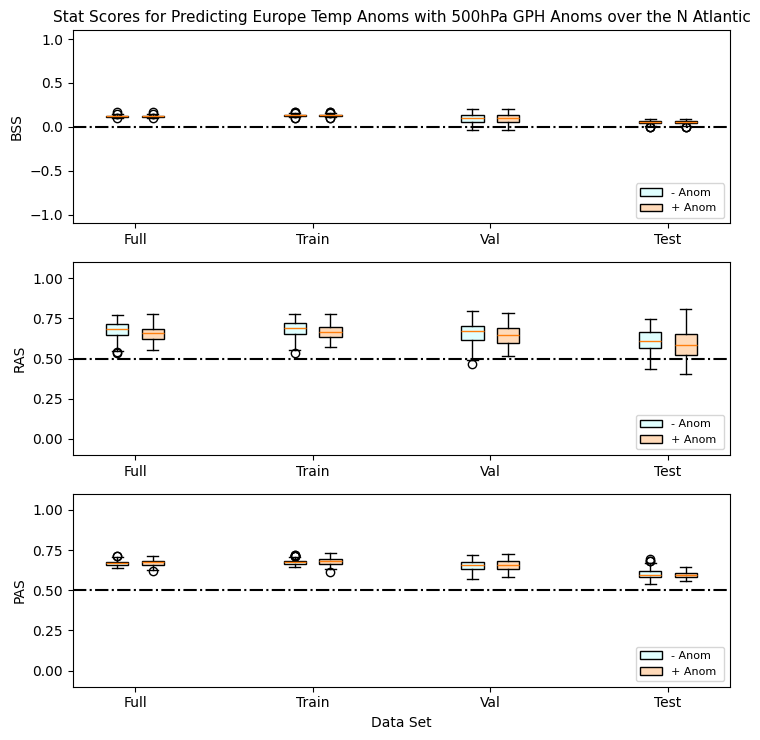

In [34]:
#plot
fig = plt.figure(figsize=(7.5,7.5))
font = 10
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting Europe Temp Anoms with 500hPa GPH Anoms over the N Atlantic",fontsize = 11) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 8)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 8)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 8)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("1121_NAOTemp_StatScore_test.png", bbox_inches='tight',dpi =150)


In [27]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

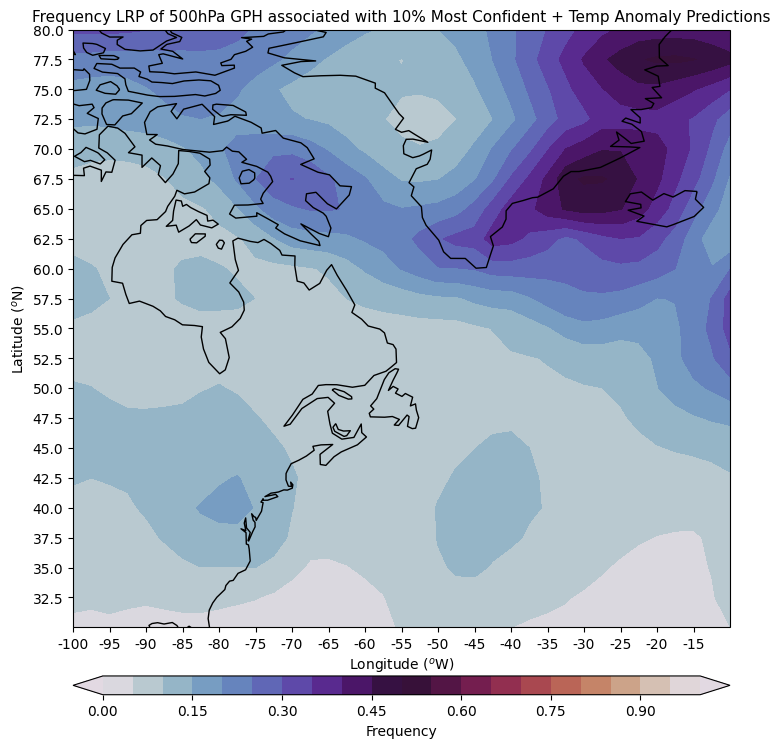

In [28]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
plt.figure(figsize=(7.5,7.5))
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))

h = ax.contourf(lons, lats, np.nanmean(pos90_LRP,axis=0), level,
                transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.07,pad=0.07,aspect=35, label = "Frequency")
cbar.ax.tick_params(labelsize=10) 

#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-2.5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=10)
ax.set_yticklabels(latg,fontsize=10)
ax.set_ylabel('Latitude ($^o$N)',fontsize=10);
ax.set_xlabel('Longitude ($^o$W)',fontsize=10);

ax.set_aspect('auto') ;

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident + Temp Anomaly Predictions'
plt.title(title,fontsize=11)
plt.savefig("1121_Pos_LRP.png", bbox_inches='tight')

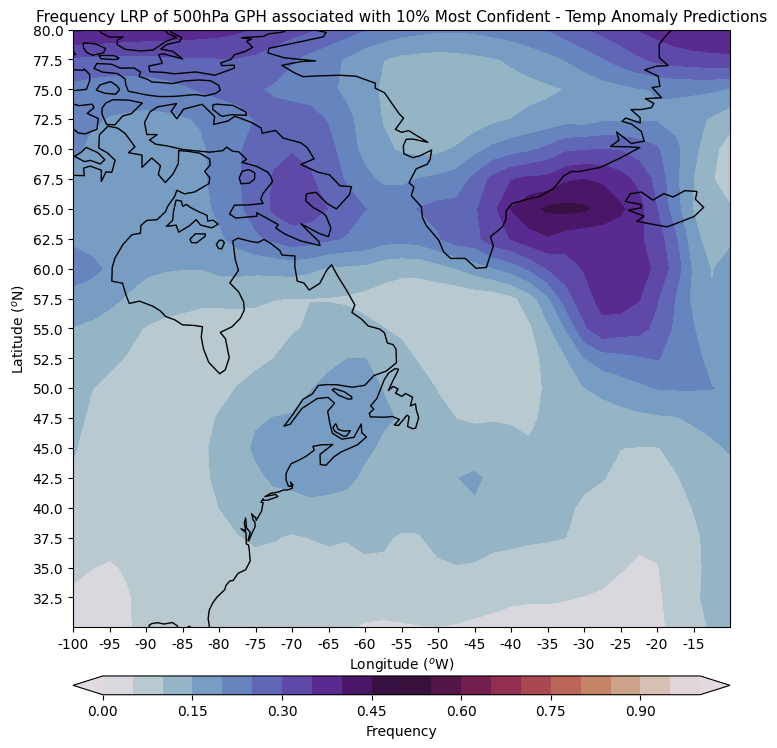

In [29]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
plt.figure(figsize=(7.5,7.5))
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))

h = ax.contourf(lons, lats, np.nanmean(neg90_LRP,axis=0), level,
                transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.07,pad=0.07,aspect=35, label = "Frequency")
cbar.ax.tick_params(labelsize=10) 

#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-2.5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=10)
ax.set_yticklabels(latg,fontsize=10)
ax.set_ylabel('Latitude ($^o$N)',fontsize=10);
ax.set_xlabel('Longitude ($^o$W)',fontsize=10);

ax.set_aspect('auto') ;

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'Frequency LRP of 500hPa GPH associated with 10% Most Confident - Temp Anomaly Predictions'
plt.title(title,fontsize=11)
plt.savefig("1121_Neg_LRP.png", bbox_inches='tight')

In [30]:
##pickle out the stuff for making heat maps because I want to run it on a smaller code
##true values
pickle.dump(neg90_LRP, open("neg90_LRP.p", 'wb'))
pickle.dump(pos90_LRP, open("pos90_LRP.p",'wb'))

##false values
pickle.dump(Fneg90_LRP, open("Fneg90_LRP.p",'wb'))
pickle.dump(Fpos90_LRP, open("Fpos90_LRP.p",'wb'))

##for composites
pickle.dump(comp_pos, open("comp_pos.p",'wb'))
pickle.dump(compFpos, open("compFpos.p",'wb'))
pickle.dump(comp_neg, open("comp_neg.p",'wb'))
pickle.dump(compFneg, open("compFneg.p",'wb'))

## Percentile ACC Plots

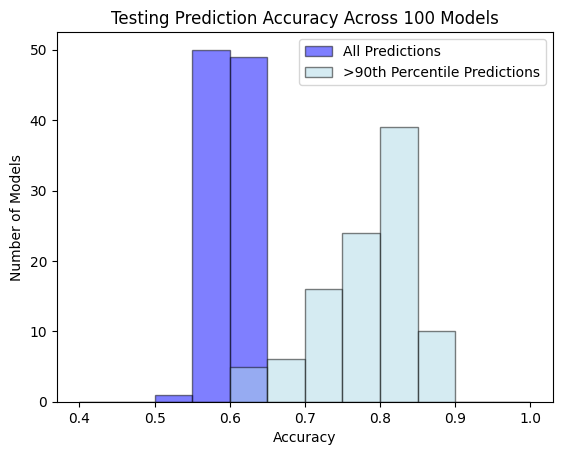

<Figure size 640x480 with 0 Axes>

In [31]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 Models')
plt.show()
plt.savefig("1121_ACCtest.png")

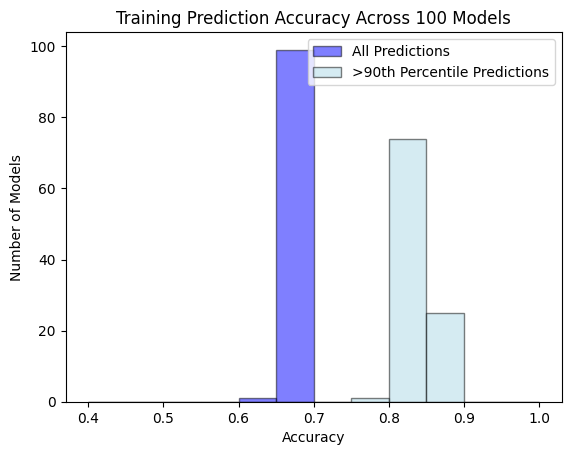

<Figure size 640x480 with 0 Axes>

In [32]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(train90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltrain_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Training Prediction Accuracy Across 100 Models')
plt.show()
plt.savefig("1121_ACCtrain.png")

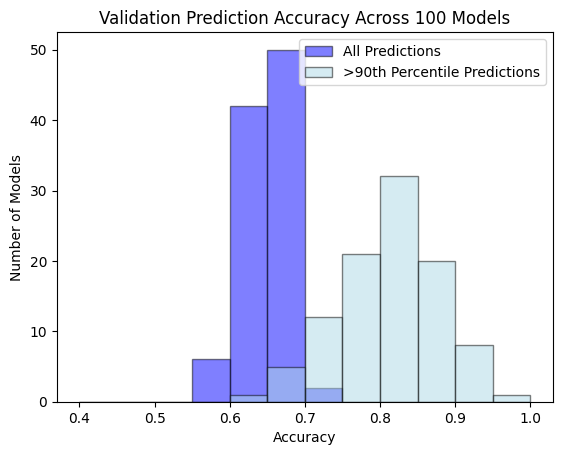

<Figure size 640x480 with 0 Axes>

In [33]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(val90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fullval_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Validation Prediction Accuracy Across 100 Models')
plt.show()
plt.savefig("1121_ACCval.png")